# Project Summary
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

We will provide you with starter code that reads in the data, takes your features of choice, then puts them into a NumPy array, which is the input form that most sklearn functions assume. Your job is to engineer the features, pick and tune an algorithm, and to test and evaluate your identifier.

As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person.

You are encouraged to make, transform or rescale new features from the starter features. If you do this, you should store the new feature to my_dataset, and if you use the new feature in the final algorithm, you should also add the feature name to my_feature_list, so your evaluator can access it during testing.

In [58]:
import sys
import pickle
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from scipy import stats

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from utils import (
    Draw,
    plotData,
    create_features,
    calculate_pct_poi_msgs,
    validate_classifier,
)

In [59]:
pp = pprint.PrettyPrinter(indent=4)
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

# set a consistent randomization
RANDOM_STATE = 42
# set a consistent number of folds/splits
FOLDS = 10

# Data Exploration

### Observations
- 146 Samples
- 21 Features
- Most features were successfully converted to a Float value. The 'email_address' feature can safely ignored because it's a non-numerical value.
- 2 samples ('THE TRAVEL AGENCY IN THE PARK', 'TOTAL') appear to not be individuals, so they will likely be removed from the dataset.
- The 'other' feature will likely be discarded because it's unclear what that feature encompasses
- 'deferred_income', 'deferral_payments', 'restricted_stock', and 'restricted_stock_deferred' have can encompass negative values

In [60]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# coerce data features to numeric values or a NaN
df = pd.DataFrame(data_dict).transpose().apply(pd.to_numeric, errors="coerce")

# copy the original DF to use for data discovery
discovery_df = df.copy()

In [61]:
discovery_df.shape

(146, 21)

In [62]:
discovery_df.describe()

bonus  deferral_payments  deferred_income  director_fees  \
count       82.00              39.00            49.00          17.00   
mean   2374234.61         1642674.15      -1140475.14      166804.88   
std   10713327.97         5161929.97       4025406.38      319891.41   
min      70000.00         -102500.00     -27992891.00        3285.00   
25%     431250.00           81573.00       -694862.00       98784.00   
50%     769375.00          227449.00       -159792.00      108579.00   
75%    1200000.00         1002671.50        -38346.00      113784.00   
max   97343619.00        32083396.00          -833.00     1398517.00   

       email_address  exercised_stock_options   expenses  from_messages  \
count           0.00                   102.00      95.00          86.00   
mean             nan               5987053.77  108728.92         608.79   
std              nan              31062006.57  533534.81        1841.03   
min              nan                  3285.00     148.00          12.00   
25%              nan                527886.25   22614.00          22.75   
50%              nan               1310813.50   46950.00          41.00   
75%              nan               2547724.00   79952.50         145.50   
max              nan             311764000.00 5235198.00       14368.00   

       from_poi_to_this_person  from_this_person_to_poi  loan_advances  \
count                    86.00                    86.00           4.00   
mean                     64.90                    41.23    41962500.00   
std                      86.98                   100.07    47083208.70   
min                       0.00                     0.00      400000.00   
25%                      10.00                     1.00     1600000.00   
50%                      35.00                     8.00    41762500.00   
75%                      72.25                    24.75    82125000.00   
max                     528.00                   609.00    83925000.00   

       long_term_incentive       other  restricted_stock  \
count                66.00       93.00            110.00   
mean            1470361.45   919064.97        2321741.14   
std             5942759.32  4589252.91       12518278.18   
min               69223.00        2.00       -2604490.00   
25%              281250.00     1215.00         254018.00   
50%              442035.00    52382.00         451740.00   
75%              938672.00   362096.00        1002369.75   
max            48521928.00 42667589.00      130322299.00   

       restricted_stock_deferred      salary  shared_receipt_with_poi  \
count                      18.00       95.00                    86.00   
mean                   166410.56   562194.29                  1176.47   
std                   4201494.31  2716369.15                  1178.32   
min                  -7576788.00      477.00                     2.00   
25%                   -389621.75   211816.00                   249.75   
50%                   -146975.00   259996.00                   740.50   
75%                    -75009.75   312117.00                  1888.25   
max                  15456290.00 26704229.00                  5521.00   

       to_messages  total_payments  total_stock_value  
count        86.00          125.00             126.00  
mean       2073.86      5081526.49         6773957.45  
std        2582.70     29061716.40        38957772.73  
min          57.00          148.00          -44093.00  
25%         541.25       394475.00          494510.25  
50%        1211.00      1101393.00         1102872.50  
75%        2634.75      2093263.00         2949846.75  
max       15149.00    309886585.00       434509511.00

In [63]:
discovery_df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

In [64]:
discovery_df

314288.00                    71.00   
CUMBERLAND MICHAEL S            184899.00                      nan   
DEFFNER JOSEPH M                206121.00                   552.00   
DELAINEY DAVID W                365163.00                  2097.00   
DERRICK JR. JAMES V             492375.00                  1401.00   
DETMERING TIMOTHY J             210500.00                      nan   
DIETRICH JANET R                250100.00                  1902.00   
DIMICHELE RICHARD G             262788.00                      nan   
DODSON KEITH                    221003.00                   114.00   
DONAHUE JR JEFFREY M            278601.00                   772.00   
DUNCAN JOHN H                         nan                      nan   
DURAN WILLIAM D                 210692.00                   599.00   
ECHOLS JOHN B                   182245.00                      nan   
ELLIOTT STEVEN                  170941.00                      nan   
FALLON JAMES B                  304588.00                  1604.00   
FASTOW ANDREW S                 440698.00                      nan   
FITZGERALD JAY L                199157.00                   723.00   
FOWLER PEGGY                          nan                    10.00   
FOY JOE                               nan                     2.00   
FREVERT MARK A                 1060932.00                  2979.00   
FUGH JOHN L                           nan                      nan   
GAHN ROBERT S                   192008.00                      nan   
GARLAND C KEVIN                 231946.00                   178.00   
GATHMANN WILLIAM D                    nan                      nan   
GIBBS DANA R                          nan                    23.00   
GILLIS JOHN                           nan                      nan   
GLISAN JR BEN F                 274975.00                   874.00   
GOLD JOSEPH                     272880.00                      nan   
GRAMM WENDY L                         nan                      nan   
GRAY RODNEY                       6615.00                      nan   
HAEDICKE MARK E                 374125.00                  1847.00   
HANNON KEVIN P                  243293.00                  1035.00   
HAUG DAVID L                          nan                   471.00   
HAYES ROBERT E                        nan                    50.00   
HAYSLETT RODERICK J                   nan                   571.00   
HERMANN ROBERT J                262663.00                      nan   
HICKERSON GARY J                211788.00                   900.00   
HIRKO JOSEPH                          nan                      nan   
HORTON STANLEY C                      nan                  1074.00   
HUGHES JAMES A                        nan                   589.00   
HUMPHREY GENE E                 130724.00                   119.00   
IZZO LAWRENCE L                  85274.00                   437.00   
JACKSON CHARLENE R              288558.00                   117.00   
JAEDICKE ROBERT                       nan                      nan   
KAMINSKI WINCENTY J             275101.00                   583.00   
KEAN STEVEN J                   404338.00                  3639.00   
KISHKILL JOSEPH G               174246.00                      nan   
KITCHEN LOUISE                  271442.00                  3669.00   
KOENIG MARK E                   309946.00                  2271.00   
KOPPER MICHAEL J                224305.00                      nan   
LAVORATO JOHN J                 339288.00                  3962.00   
LAY KENNETH L                  1072321.00                  2411.00   
LEFF DANIEL P                   273746.00                  2672.00   
LEMAISTRE CHARLES                     nan                      nan   
LEWIS RICHARD                         nan                   739.00   
LINDHOLM TOD A                  236457.00                      nan   
LOCKHART EUGENE E                     nan                      nan   
LOWRY CHARLES P                       nan 

In [65]:
# List of potential POIs
list(discovery_df.index)

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID',
 'BERGSIEKER RICHARD P',
 'BHATNAGAR SANJAY',
 'BIBI PHILIPPE A',
 'BLACHMAN JEREMY M',
 'BLAKE JR. NORMAN P',
 'BOWEN JR RAYMOND M',
 'BROWN MICHAEL',
 'BUCHANAN HAROLD G',
 'BUTTS ROBERT H',
 'BUY RICHARD B',
 'CALGER CHRISTOPHER F',
 'CARTER REBECCA C',
 'CAUSEY RICHARD A',
 'CHAN RONNIE',
 'CHRISTODOULOU DIOMEDES',
 'CLINE KENNETH W',
 'COLWELL WESLEY',
 'CORDES WILLIAM R',
 'COX DAVID',
 'CUMBERLAND MICHAEL S',
 'DEFFNER JOSEPH M',
 'DELAINEY DAVID W',
 'DERRICK JR. JAMES V',
 'DETMERING TIMOTHY J',
 'DIETRICH JANET R',
 'DIMICHELE RICHARD G',
 'DODSON KEITH',
 'DONAHUE JR JEFFREY M',
 'DUNCAN JOHN H',
 'DURAN WILLIAM D',
 'ECHOLS JOHN B',
 'ELLIOTT STEVEN',
 'FALLON JAMES B',
 'FASTOW ANDREW S',
 'FITZGERALD JAY L',
 'FOWLER PEGGY',
 'FOY JOE',
 'FREVERT MARK A',
 'FUGH JOHN L',
 'GAHN 

In [66]:
# List of Features
list(discovery_df.columns)

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

In [67]:
discovery_df.head()

bonus  deferral_payments  deferred_income  \
ALLEN PHILLIP K    4175000.00         2869717.00      -3081055.00   
BADUM JAMES P             nan          178980.00              nan   
BANNANTINE JAMES M        nan                nan         -5104.00   
BAXTER JOHN C      1200000.00         1295738.00      -1386055.00   
BAY FRANKLIN R      400000.00          260455.00       -201641.00   

                    director_fees  email_address  exercised_stock_options  \
ALLEN PHILLIP K               nan            nan               1729541.00   
BADUM JAMES P                 nan            nan                257817.00   
BANNANTINE JAMES M            nan            nan               4046157.00   
BAXTER JOHN C                 nan            nan               6680544.00   
BAY FRANKLIN R                nan            nan                      nan   

                    expenses  from_messages  from_poi_to_this_person  \
ALLEN PHILLIP K     13868.00        2195.00                    47.00   
BADUM JAMES P        3486.00            nan                      nan   
BANNANTINE JAMES M  56301.00          29.00                    39.00   
BAXTER JOHN C       11200.00            nan                      nan   
BAY FRANKLIN R     129142.00            nan                      nan   

                    from_this_person_to_poi  loan_advances  \
ALLEN PHILLIP K                       65.00            nan   
BADUM JAMES P                           nan            nan   
BANNANTINE JAMES M                     0.00            nan   
BAXTER JOHN C                           nan            nan   
BAY FRANKLIN R                          nan            nan   

                    long_term_incentive      other    poi  restricted_stock  \
ALLEN PHILLIP K               304805.00     152.00  False         126027.00   
BADUM JAMES P                       nan        nan  False               nan   
BANNANTINE JAMES M                  nan  864523.00  False        1757552.00   
BAXTER JOHN C                1586055.00 2660303.00  False        3942714.00   
BAY FRANKLIN R                      nan      69.00  False         145796.00   

                    restricted_stock_deferred    salary  \
ALLEN PHILLIP K                    -126027.00 201955.00   
BADUM JAMES P                             nan       nan   
BANNANTINE JAMES M                 -560222.00    477.00   
BAXTER JOHN C                             nan 267102.00   
BAY FRANKLIN R                      -82782.00 239671.00   

                    shared_receipt_with_poi  to_messages  total_payments  \
ALLEN PHILLIP K                     1407.00      2902.00      4484442.00   
BADUM JAMES P                           nan          nan       182466.00   
BANNANTINE JAMES M                   465.00       566.00       916197.00   
BAXTER JOHN C                           nan          nan      5634343.00   
BAY FRANKLIN R                          nan          nan       827696.00   

                    total_stock_value  
ALLEN PHILLIP K            1729541.00  
BADUM JAMES P               257817.00  
BANNANTINE JAMES M         5243487.00  
BAXTER JOHN C             10623258.00  
BAY FRANKLIN R               63014.00

### Visual Feature Distributions 

- Several features have a positively-skewed distribution or outliers and maybe benefit from feature scaling to bring values to a standard range.
- None of the features resemble a standard distribution
- Using all data features and a KNN Classifier, we achieve 88.29% with a Standard Deviation of 5.49.

Accuracy: 88.29%
Standard Deviation: 5.49


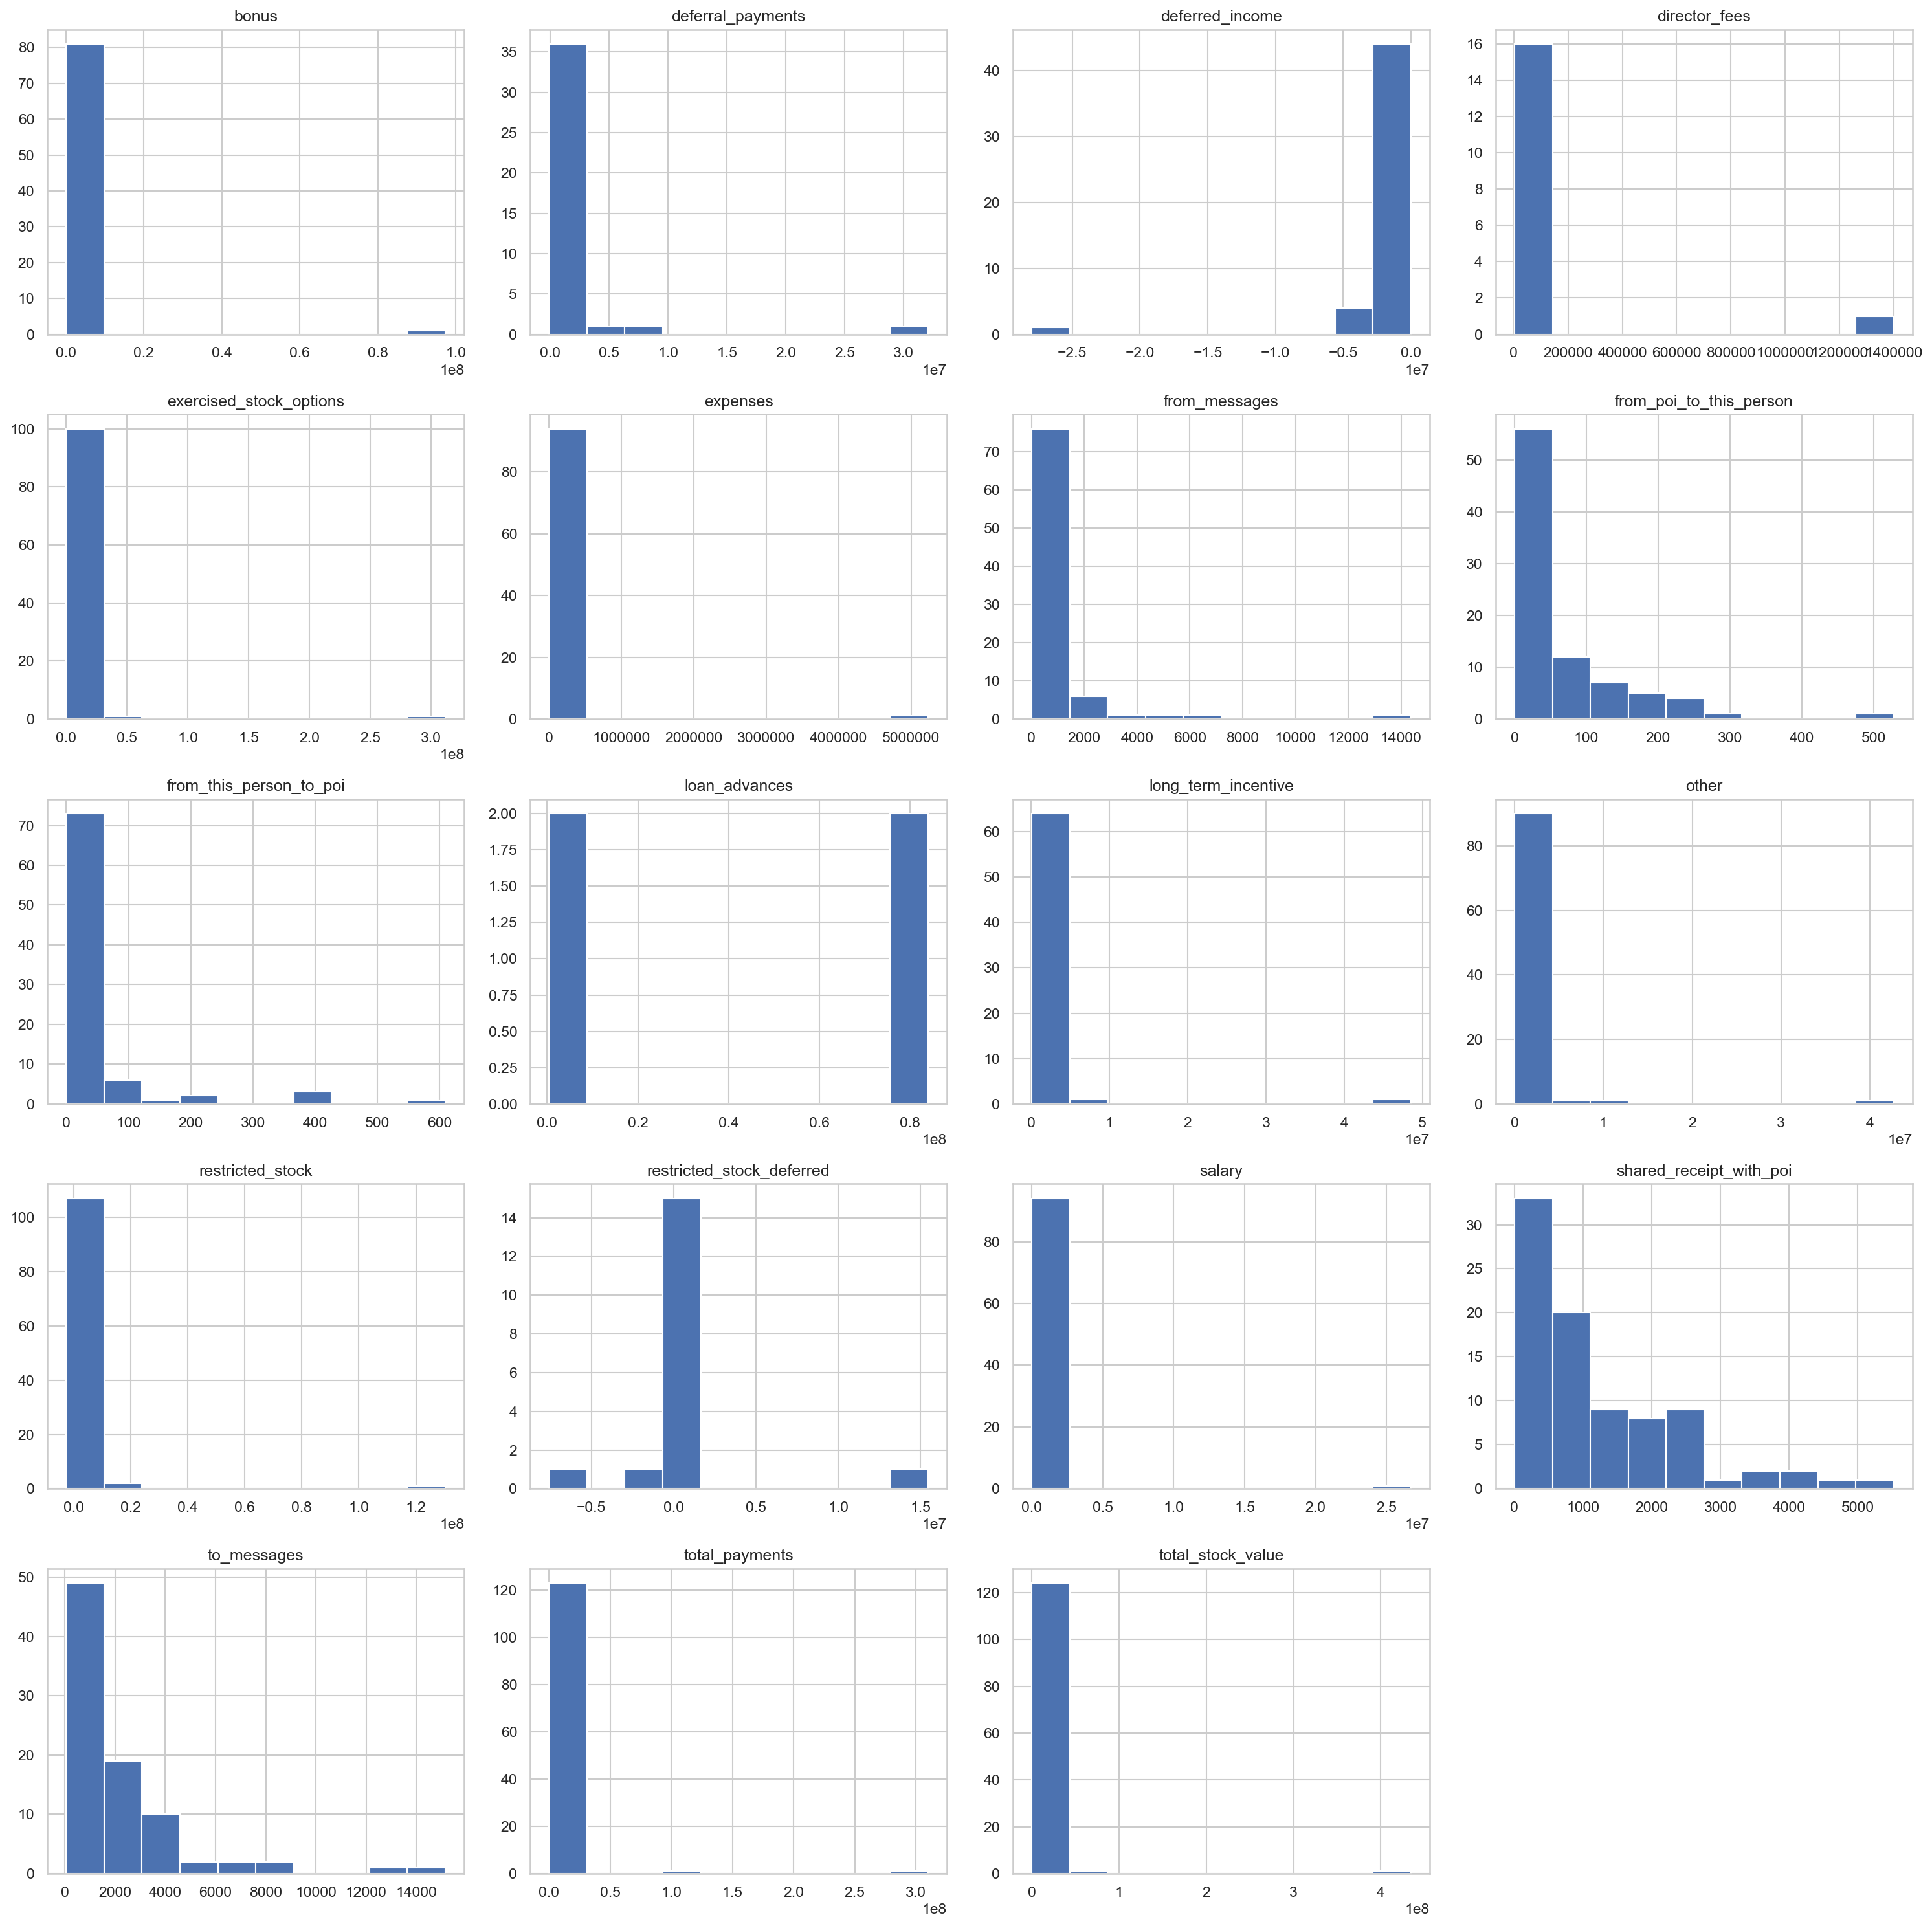

In [68]:
from sklearn.model_selection import RepeatedStratifiedKFold

# create a histogram of data features (excluding non-numerical features)
discovery_df.loc[:, ~discovery_df.columns.isin(["poi", "email_address"])].hist(
    figsize=(20, 20)
)
# drop non-individuals
discovery_df = discovery_df.drop(
    ["TOTAL", "THE TRAVEL AGENCY IN THE PARK"], errors="ignore", axis=0
)

# set X as all columns except for the Target Feature (POI)
# set y as the Target Feature (POI)
X, y = discovery_df.loc[:, ~discovery_df.columns.isin(["poi"])], discovery_df["poi"]

# fill in NaN values
X = X.fillna(0)

# create a baseline test model to see the initial accuracy when using all features
model = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=3, random_state=RANDOM_STATE)

# cross validate the model and store the scores
scores = (
    cross_val_score(model, X, y, scoring="accuracy", cv=cv, error_score="raise") * 100
)

print(
    "Accuracy: {:.2f}%\nStandard Deviation: {:.2f}".format(scores.mean(), scores.std())
)

plt.tight_layout()
plt.show()

### Explore Feature Scaling
The hypothesis is that by scaling all features to a standard range, we can compensate for large values and outliers that may potentially overpower features with smaller values -- thus skewing the results of some of our models. We'll test this using a KNN model with default parameters and a RobustScaler that will scale values using a Quantile Range. The RobustScaler essentially allows us to ignore outliers when calculating the "middle" of the distribution, and then scale the outliers using the statistical median.

Observations
- Using the RobustScaler did not improve our accuracy, in fact it decreased our accuracy across all quantile range permutations.
- The selected Quantile Range has an impact on accuracy as well the standard deviation within a cross-validated score
- The range with the smallest amount of deviation in accuracy was (20, 80)
- The range with the largest amount of deviation in accuracy was (30, 70)

These results aren't entirely conclusive, because our actual ML model will not use this many features and not every will benefit from scaling.

(0, 100) Range, Accuracy: 86.26%, Standard Deviation: 4.68
(1, 99) Range, Accuracy: 87.38%, Standard Deviation: 4.26
(5, 95) Range, Accuracy: 85.99%, Standard Deviation: 5.05
(10, 90) Range, Accuracy: 86.48%, Standard Deviation: 4.85
(15, 85) Range, Accuracy: 86.00%, Standard Deviation: 6.06
(20, 80) Range, Accuracy: 86.22%, Standard Deviation: 4.06
(25, 75) Range, Accuracy: 85.78%, Standard Deviation: 5.54
(30, 70) Range, Accuracy: 83.78%, Standard Deviation: 8.66
(35, 65) Range, Accuracy: 85.93%, Standard Deviation: 5.04


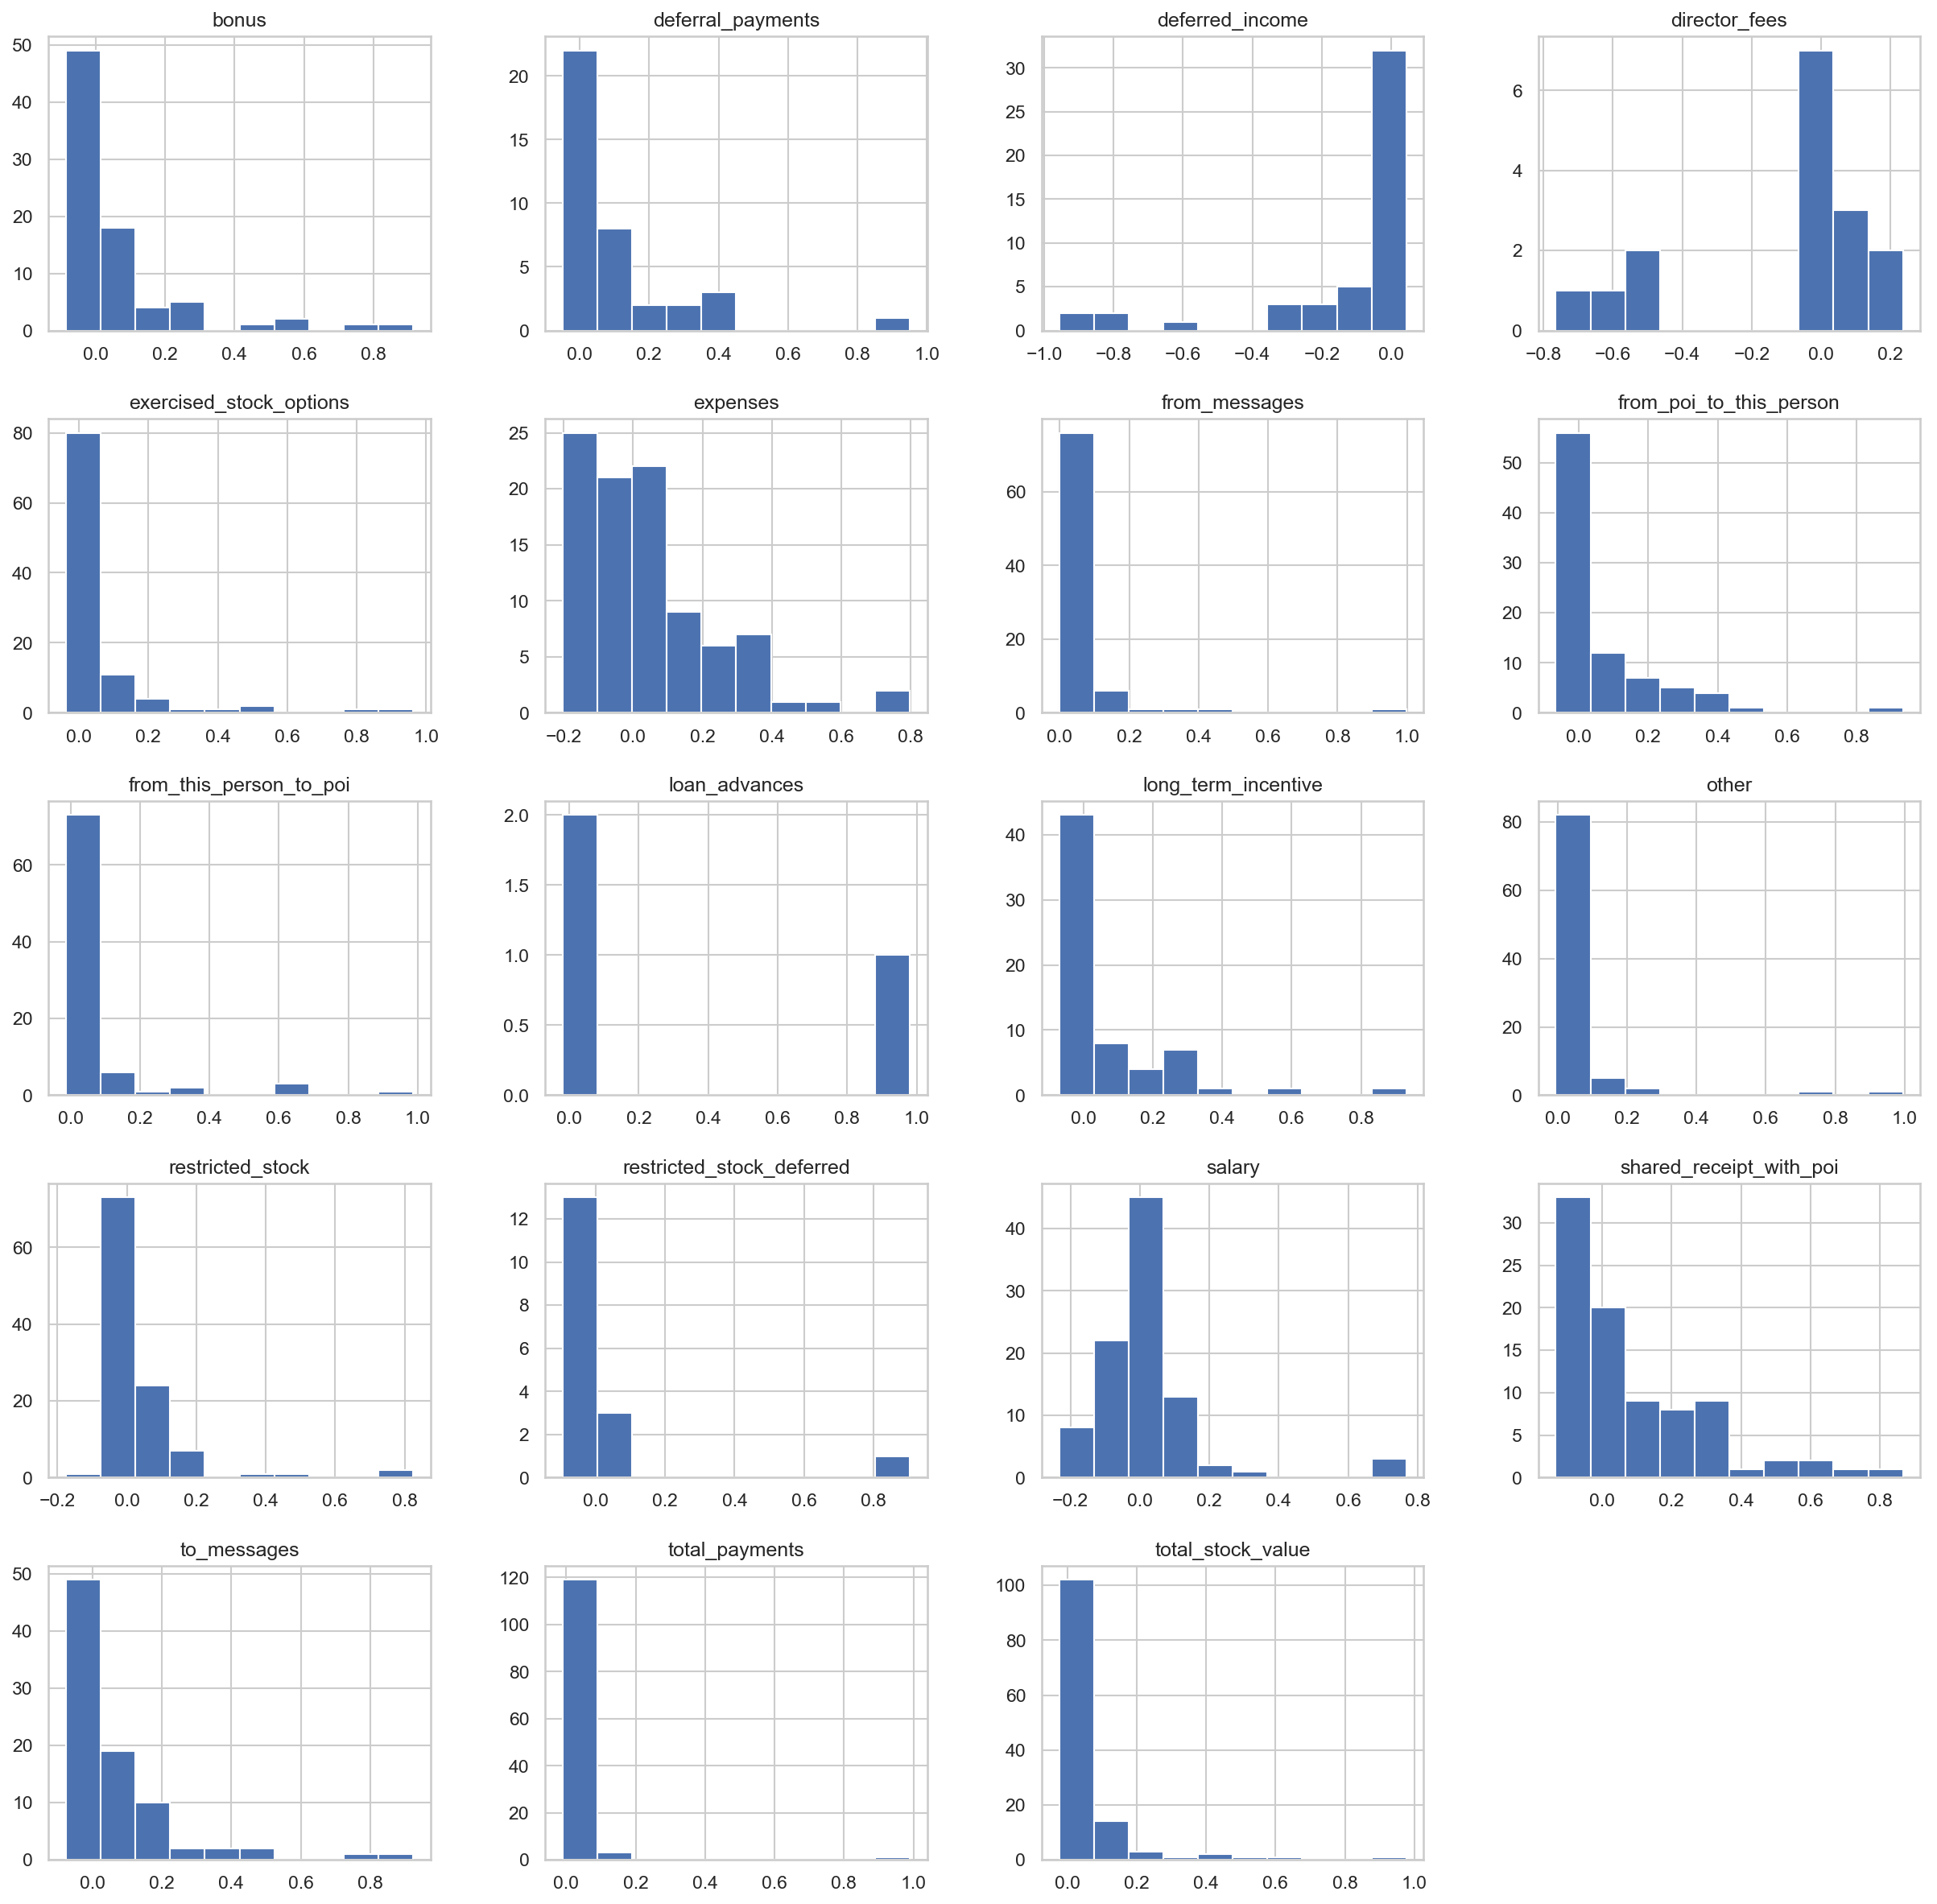

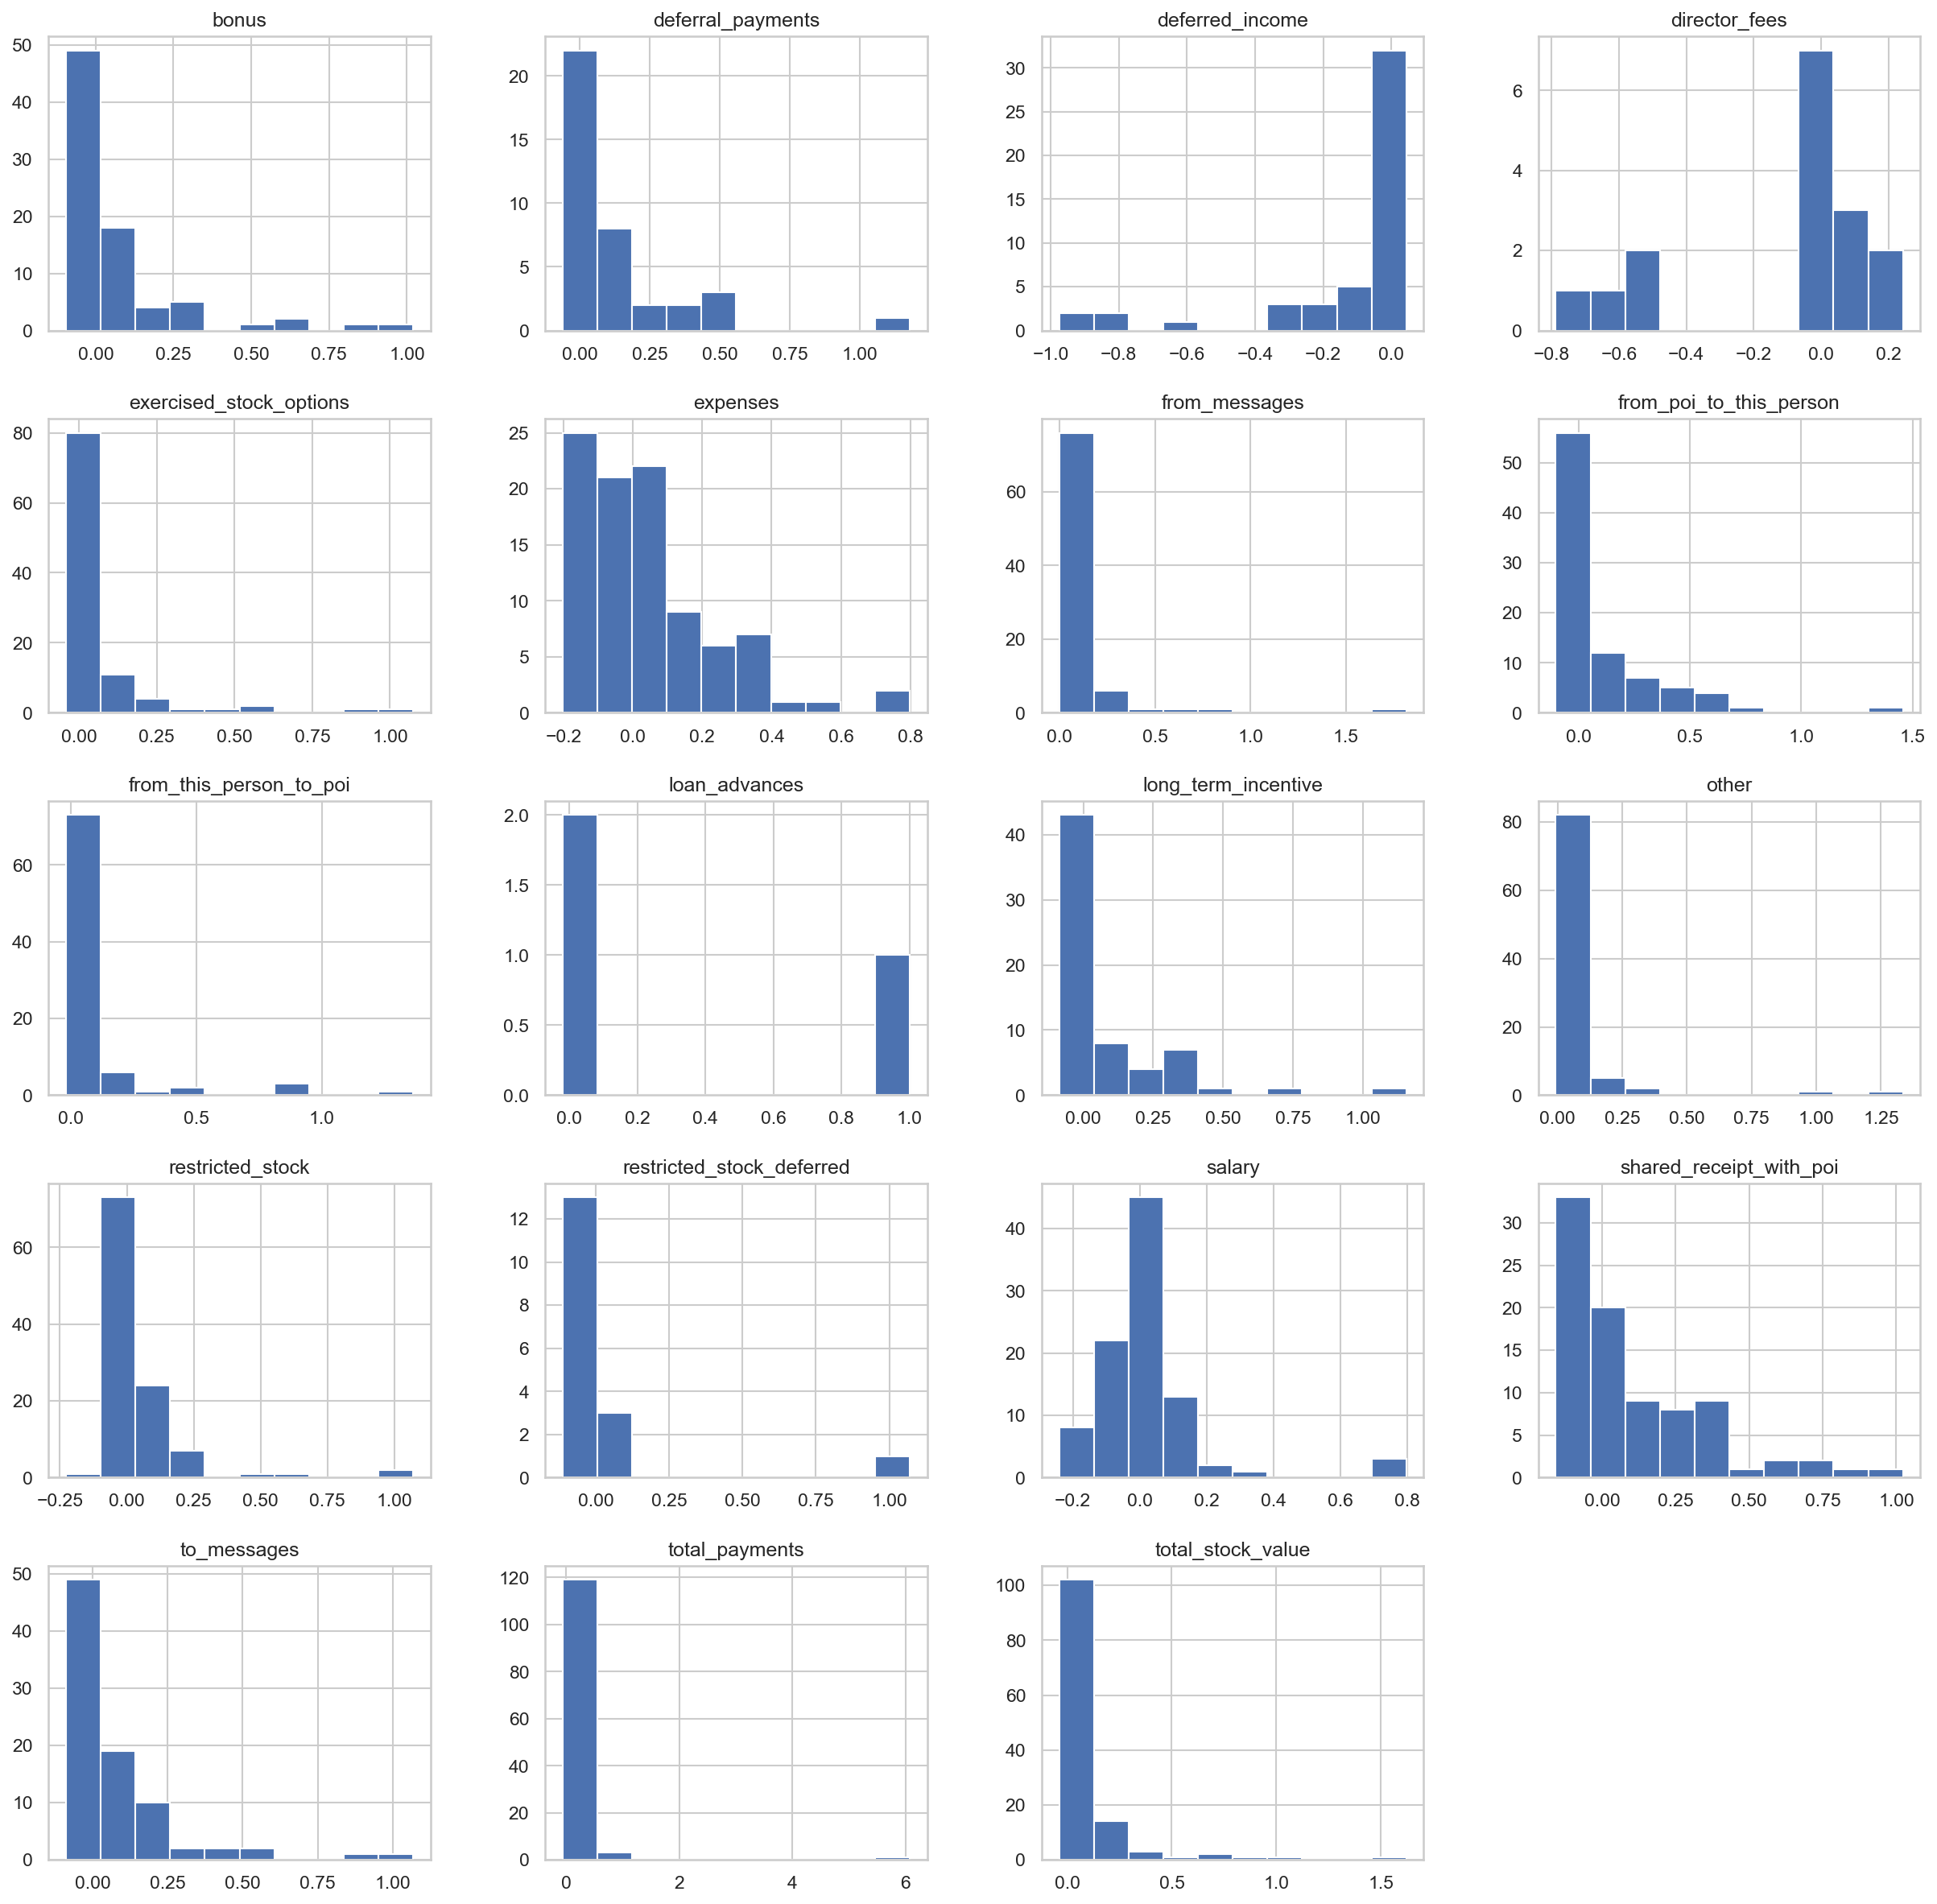

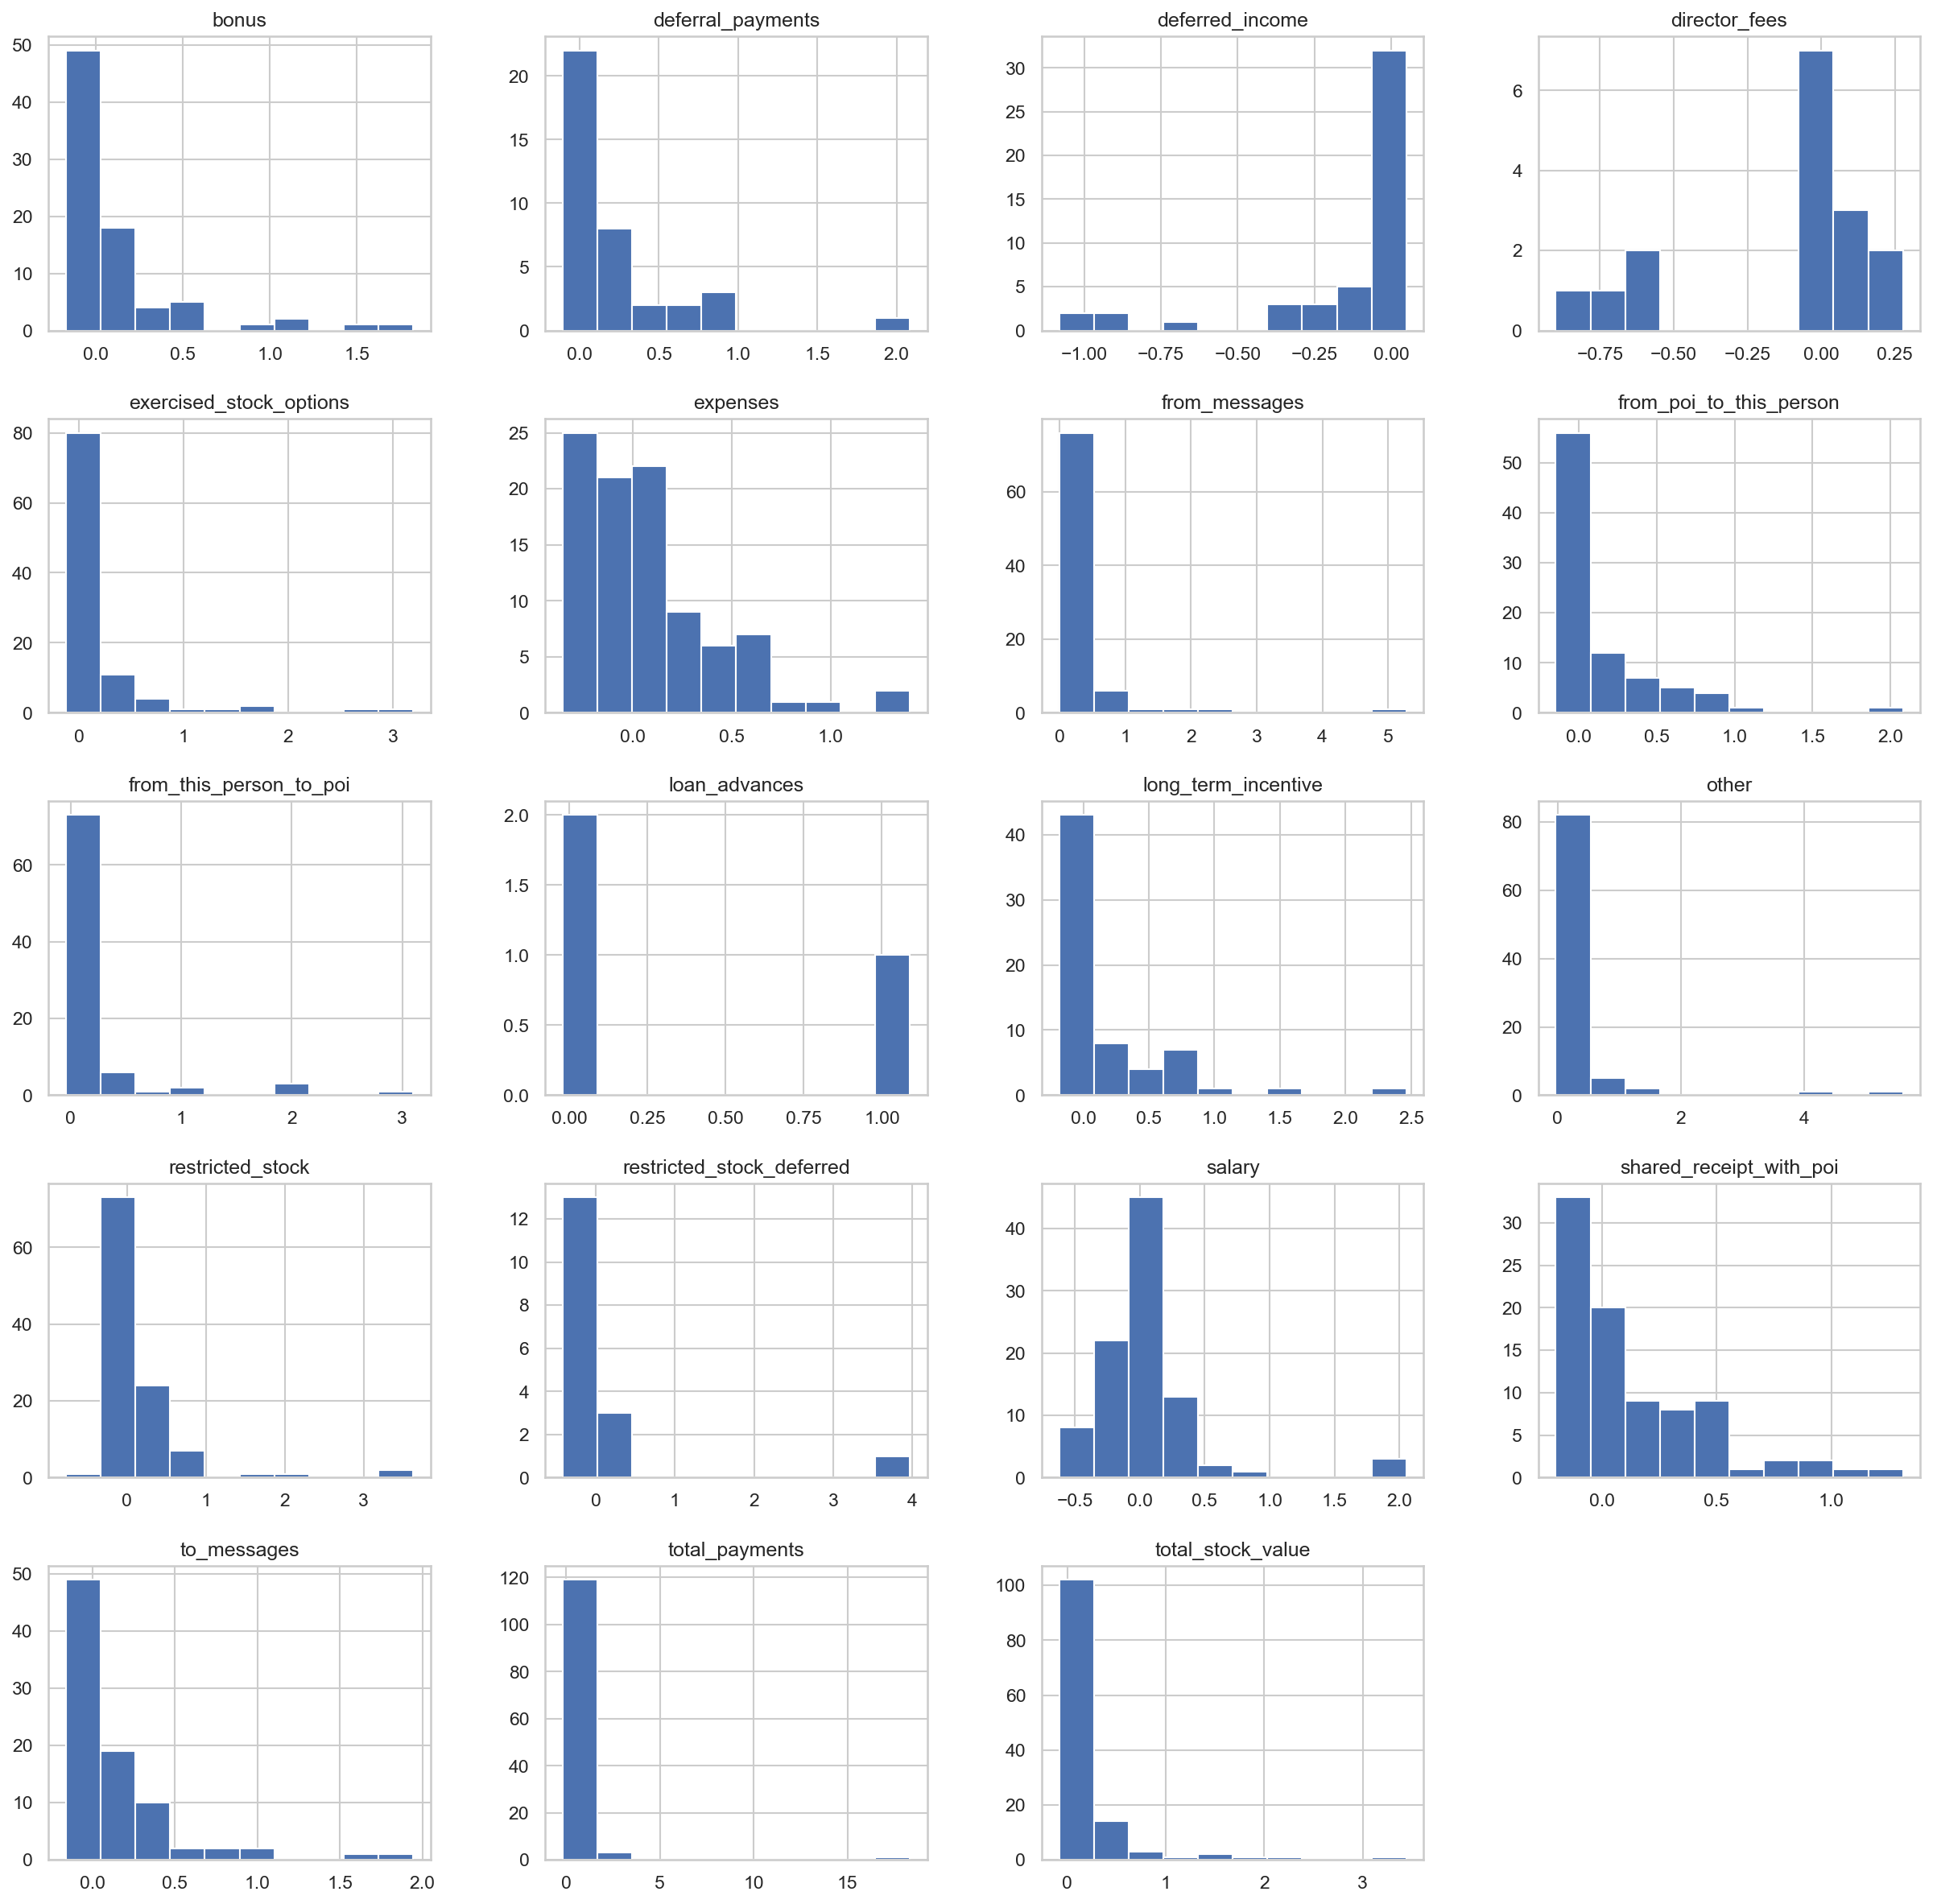

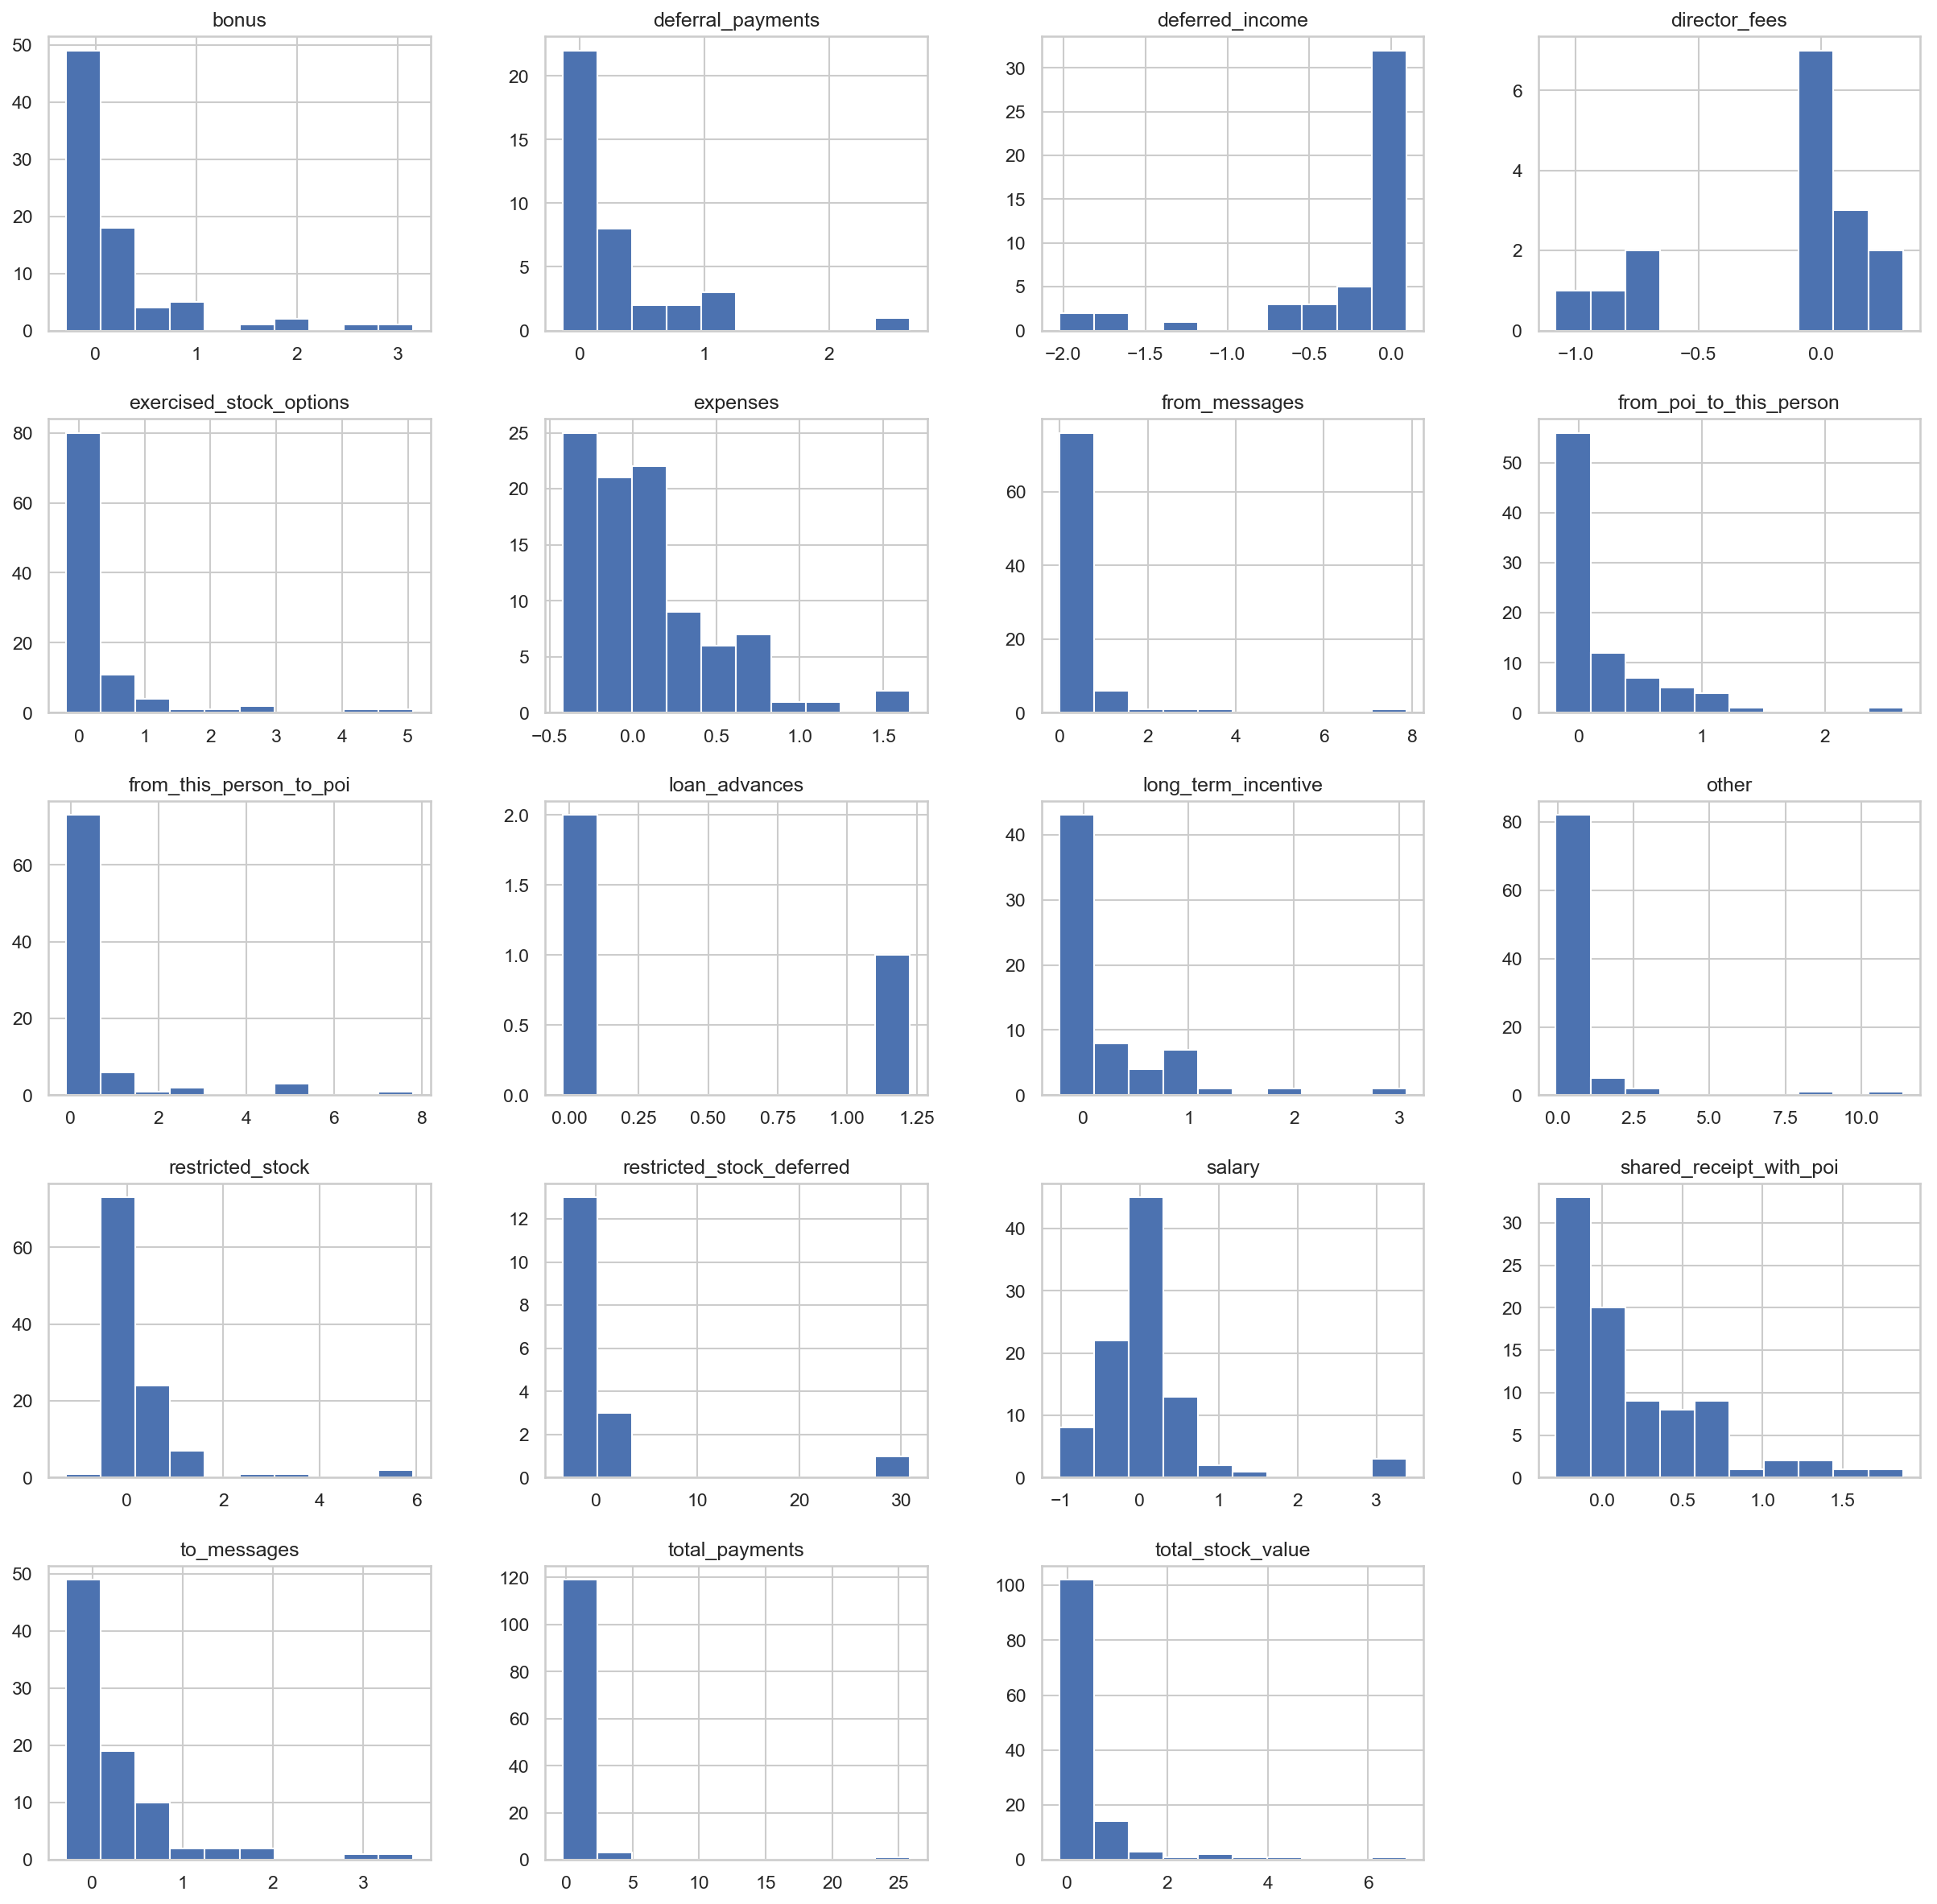

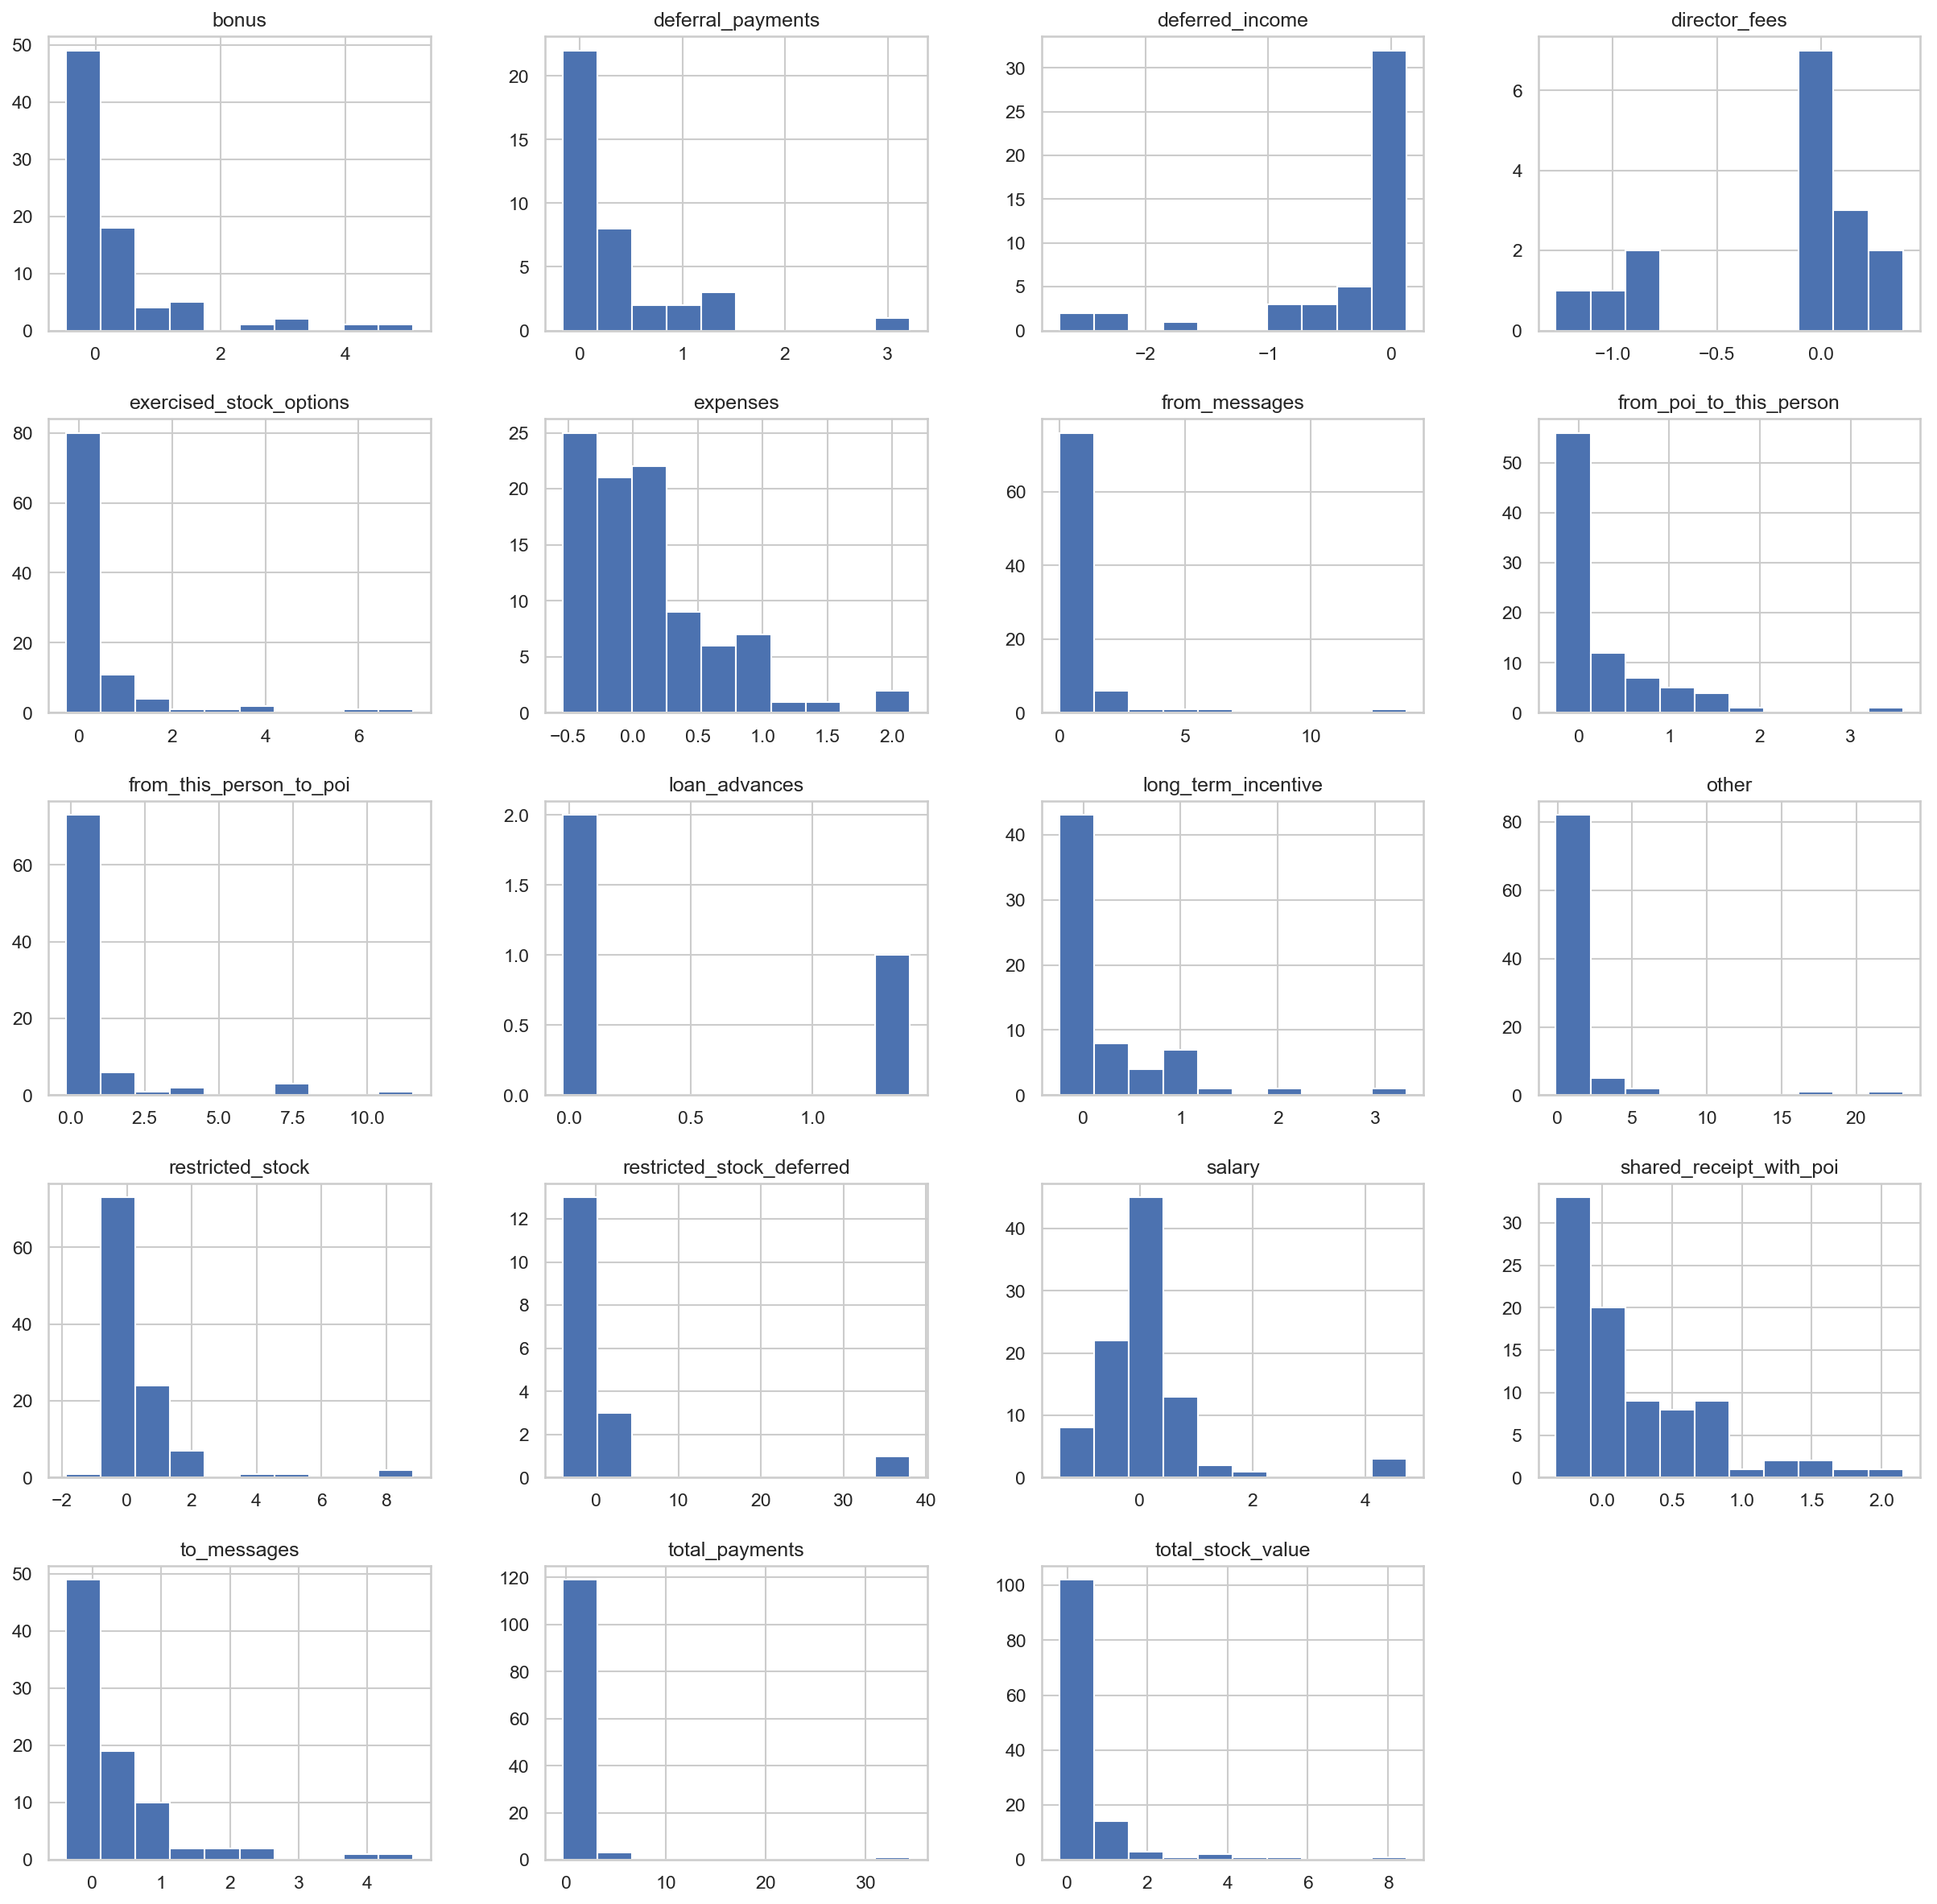

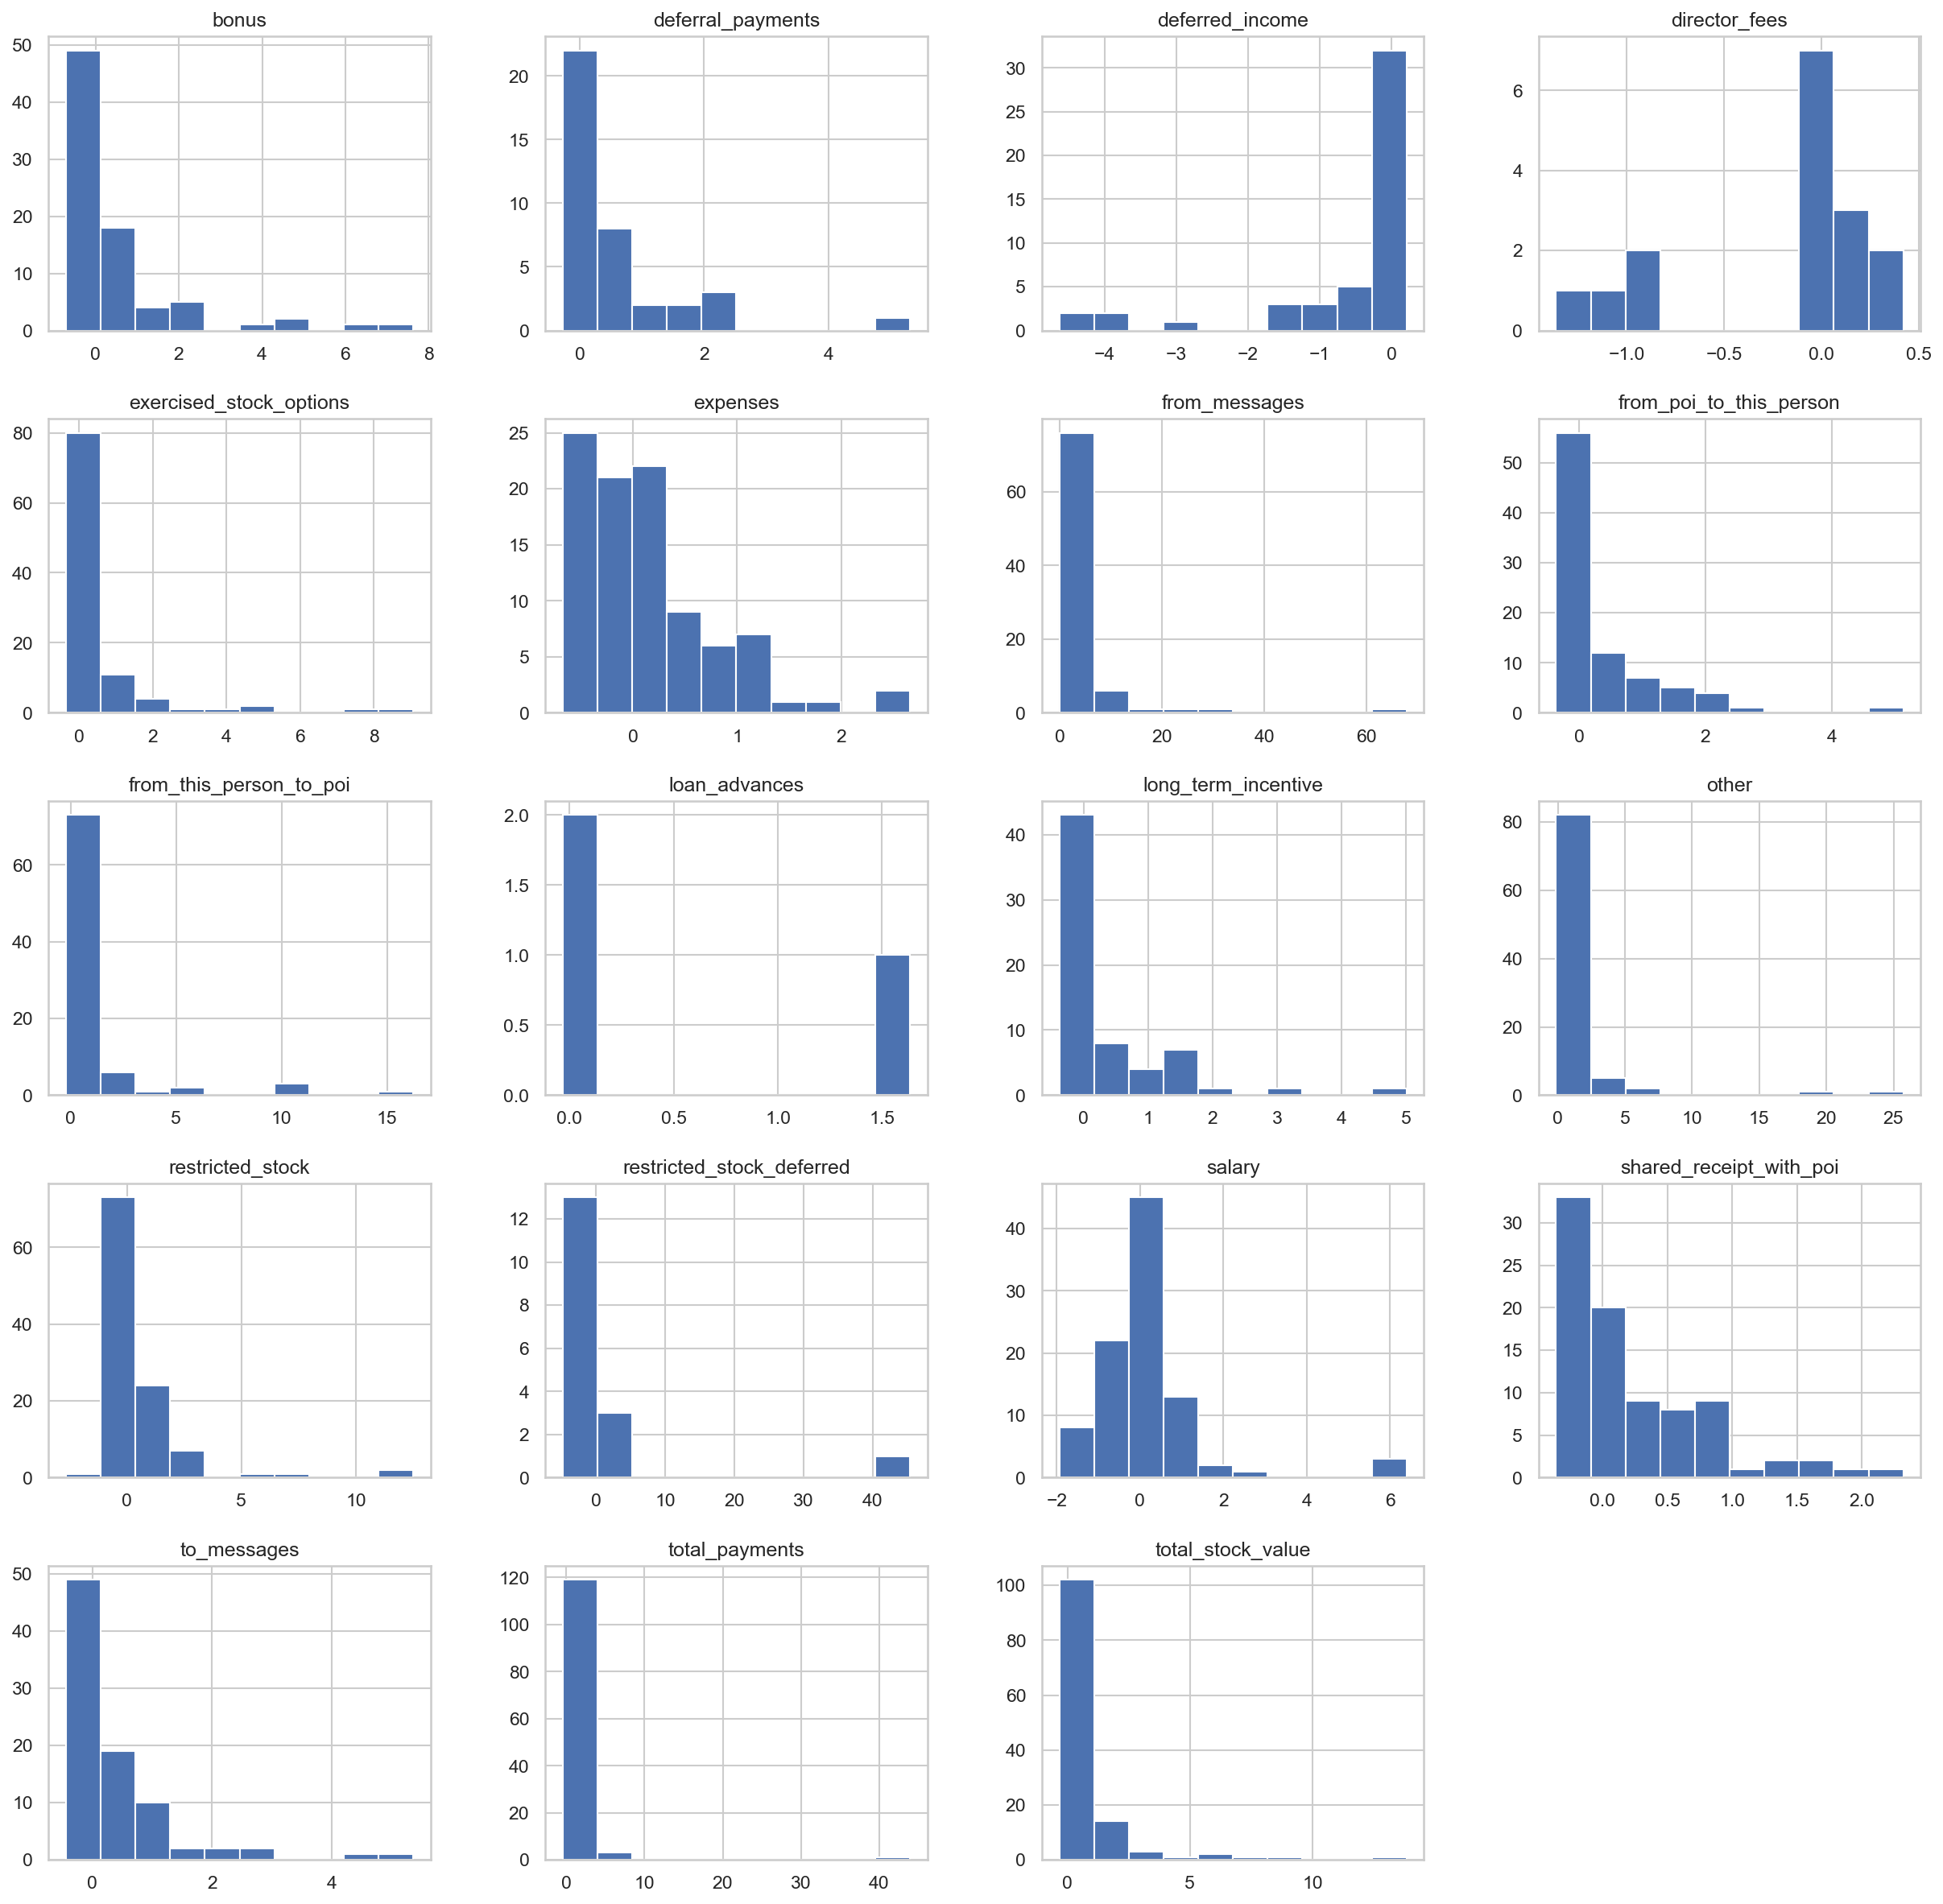

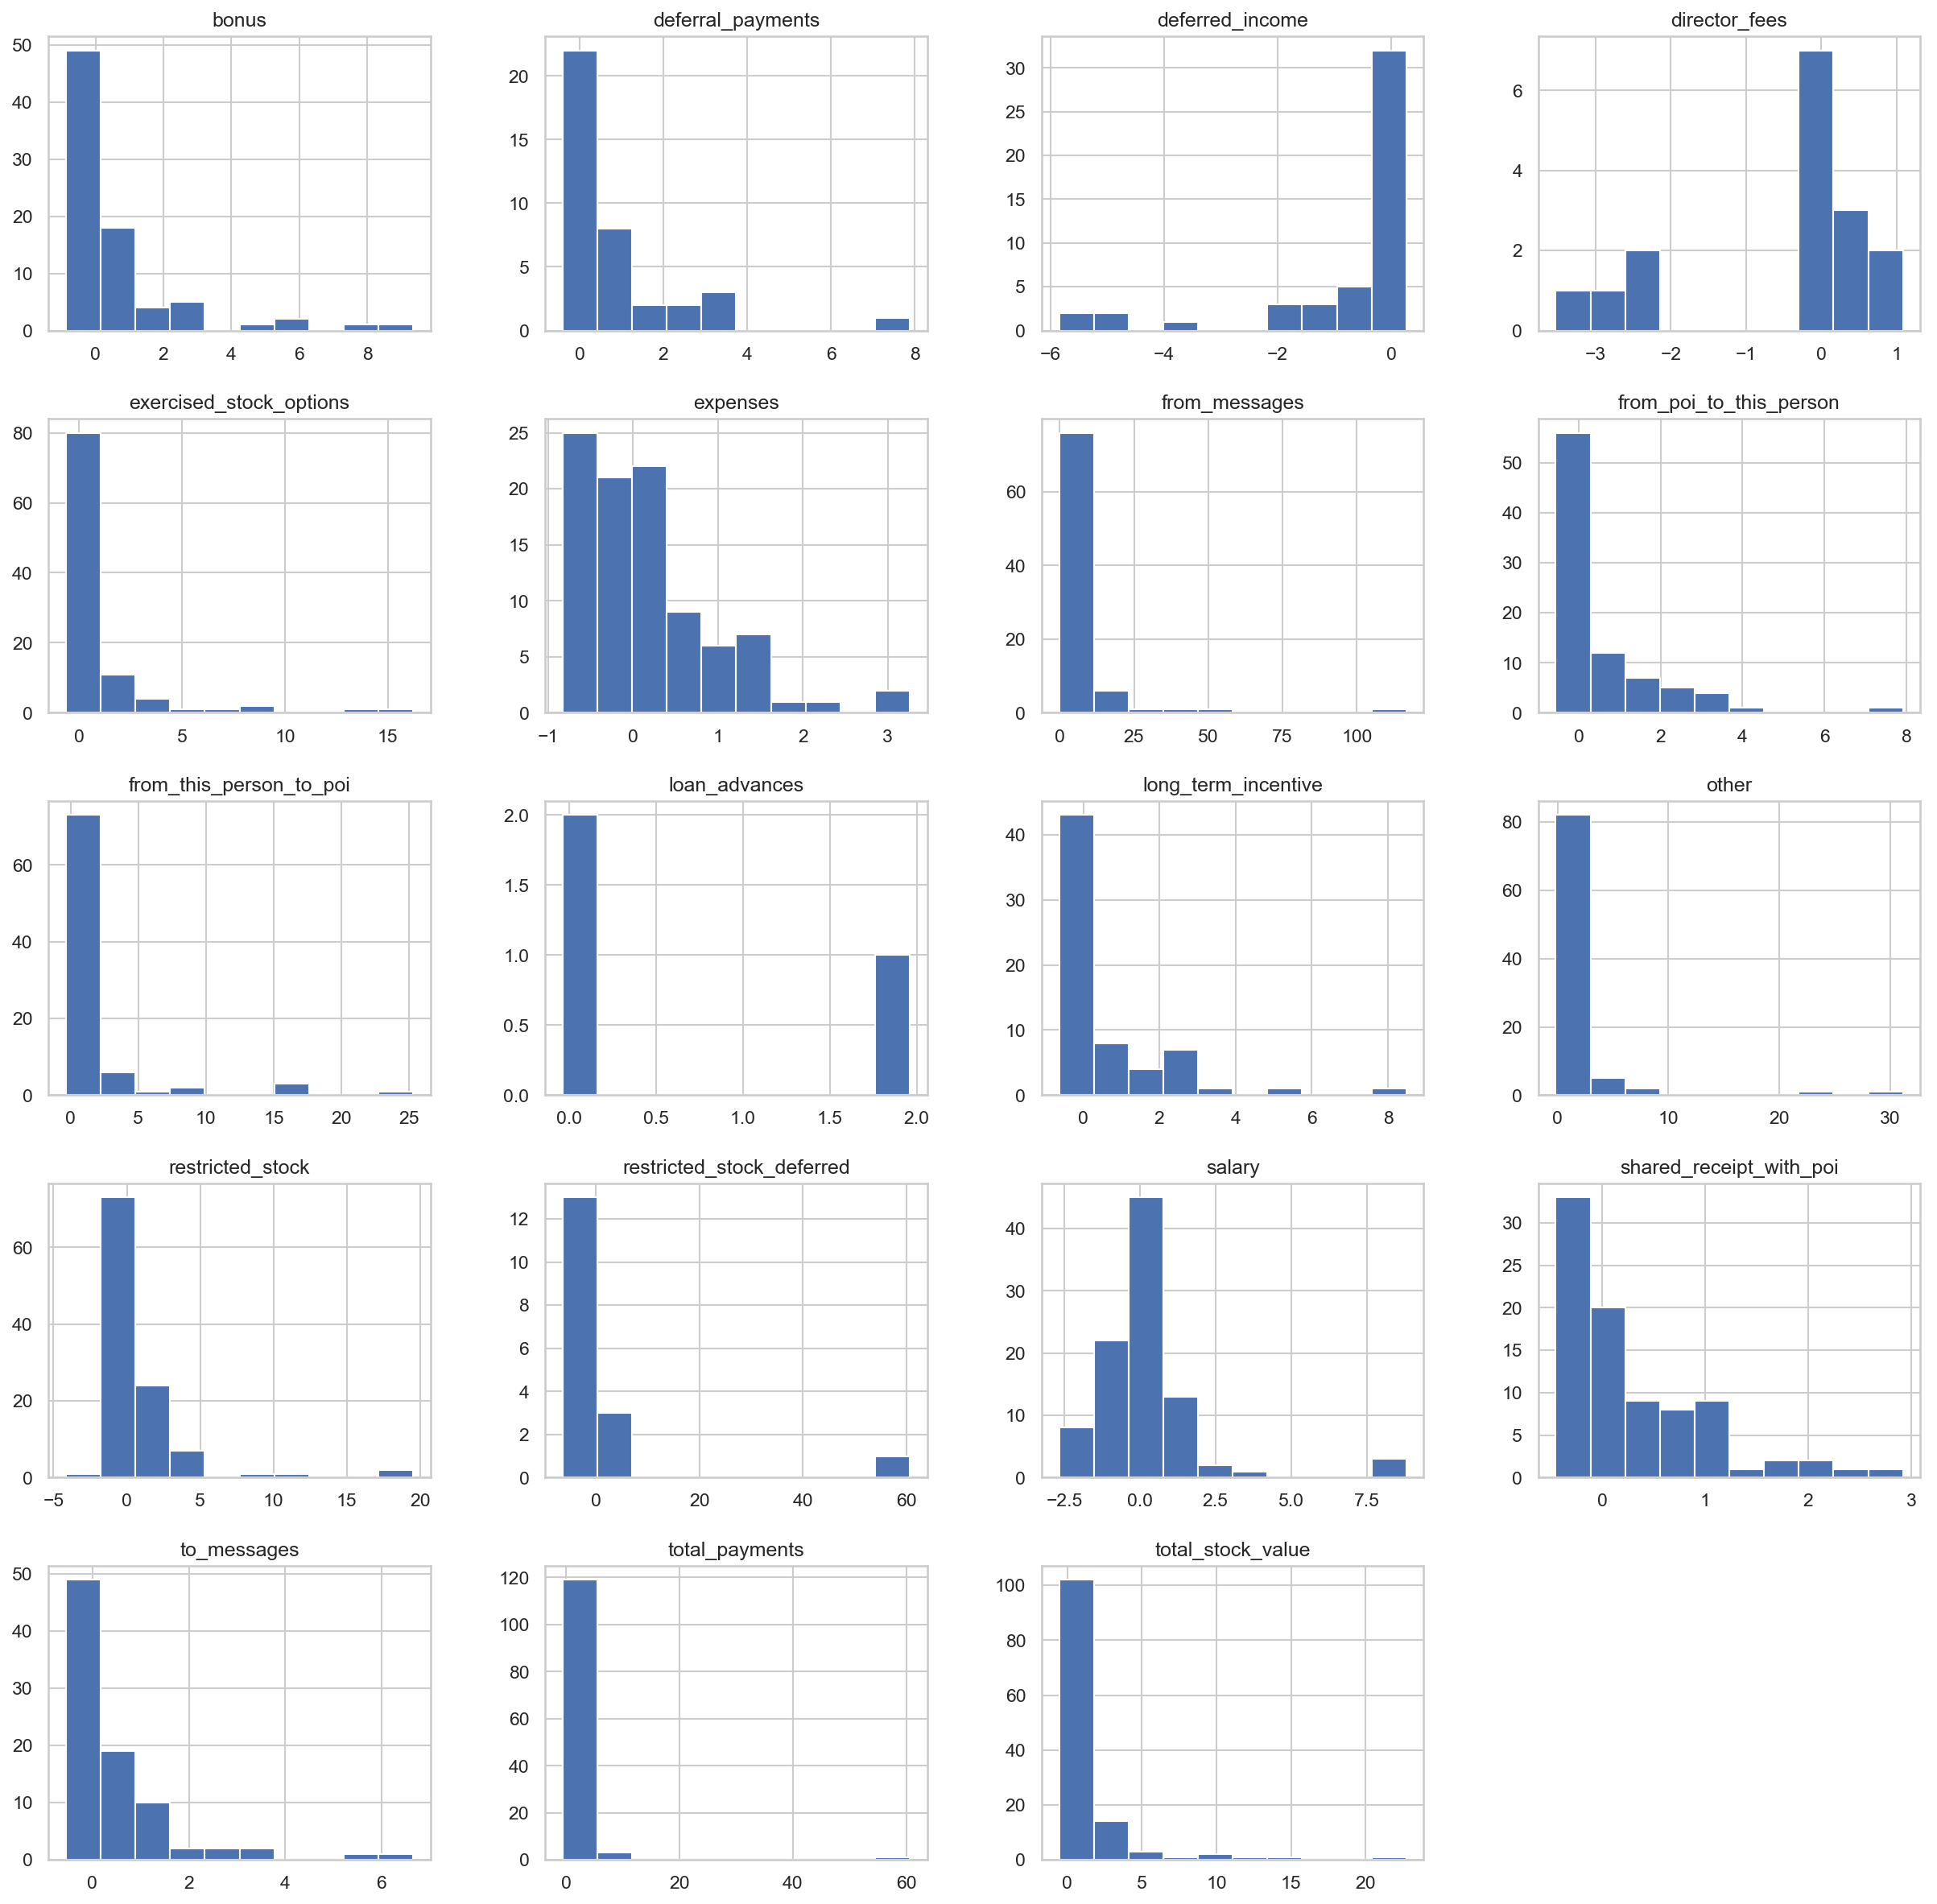

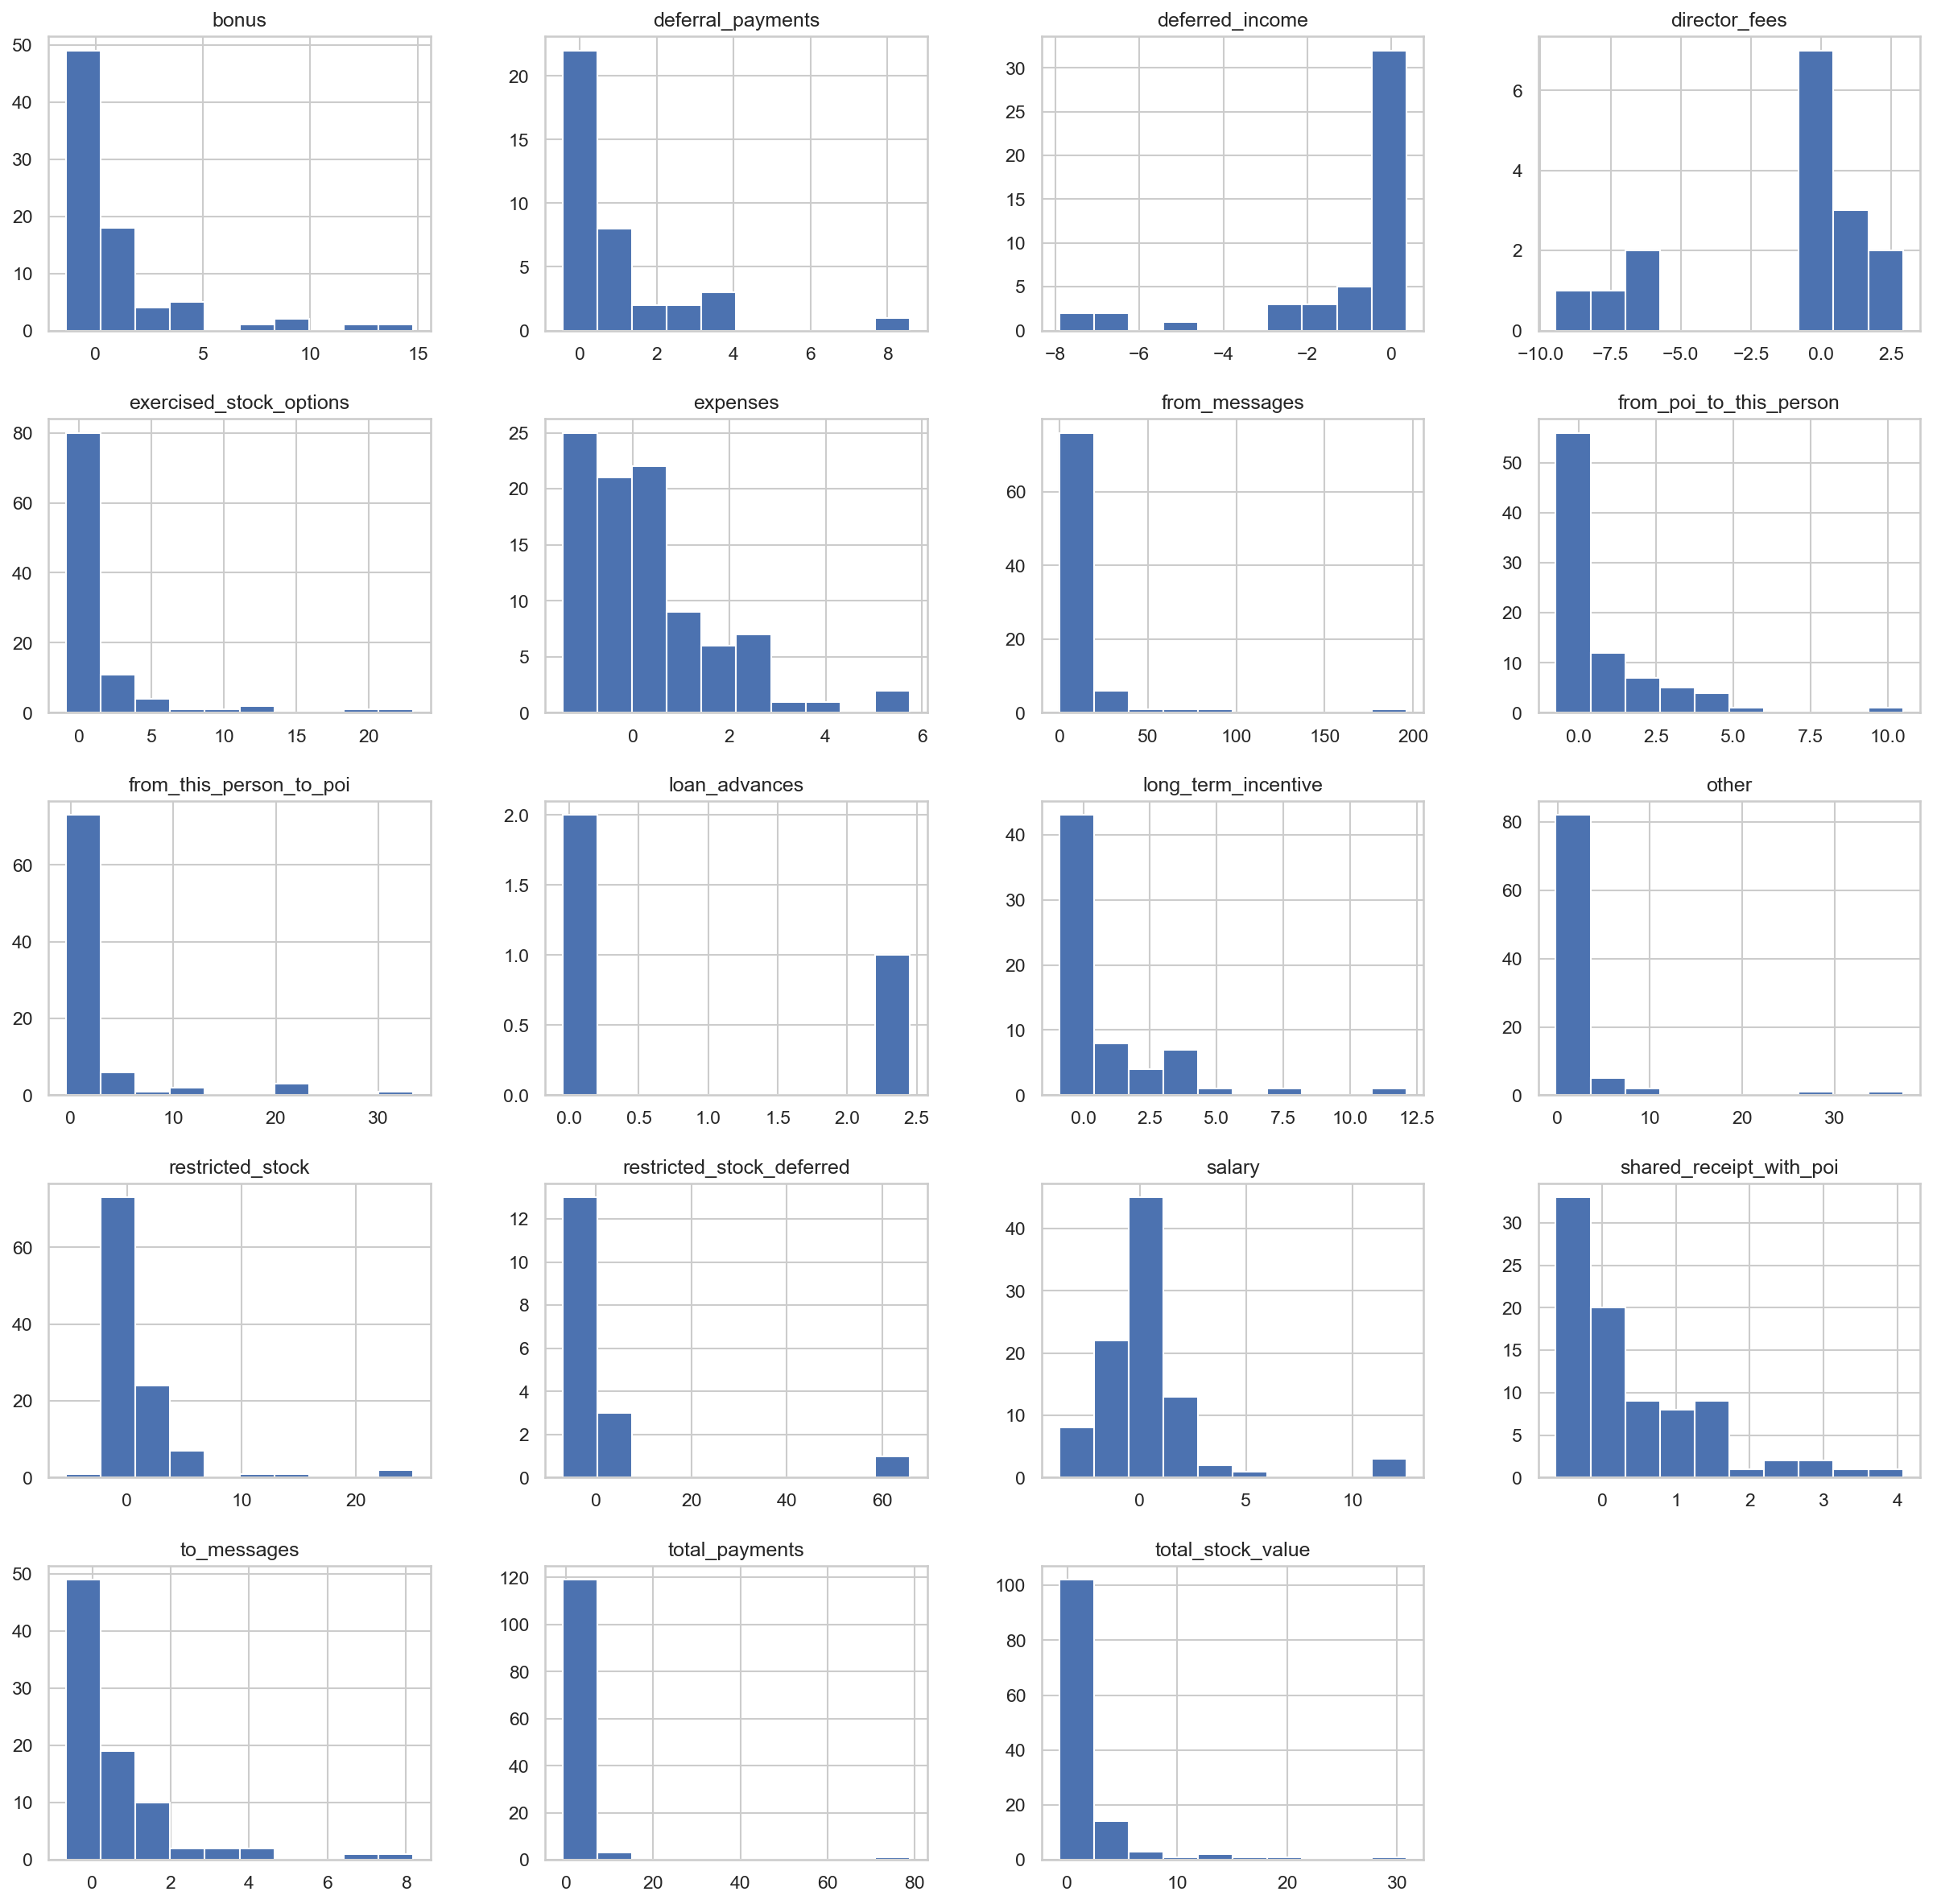

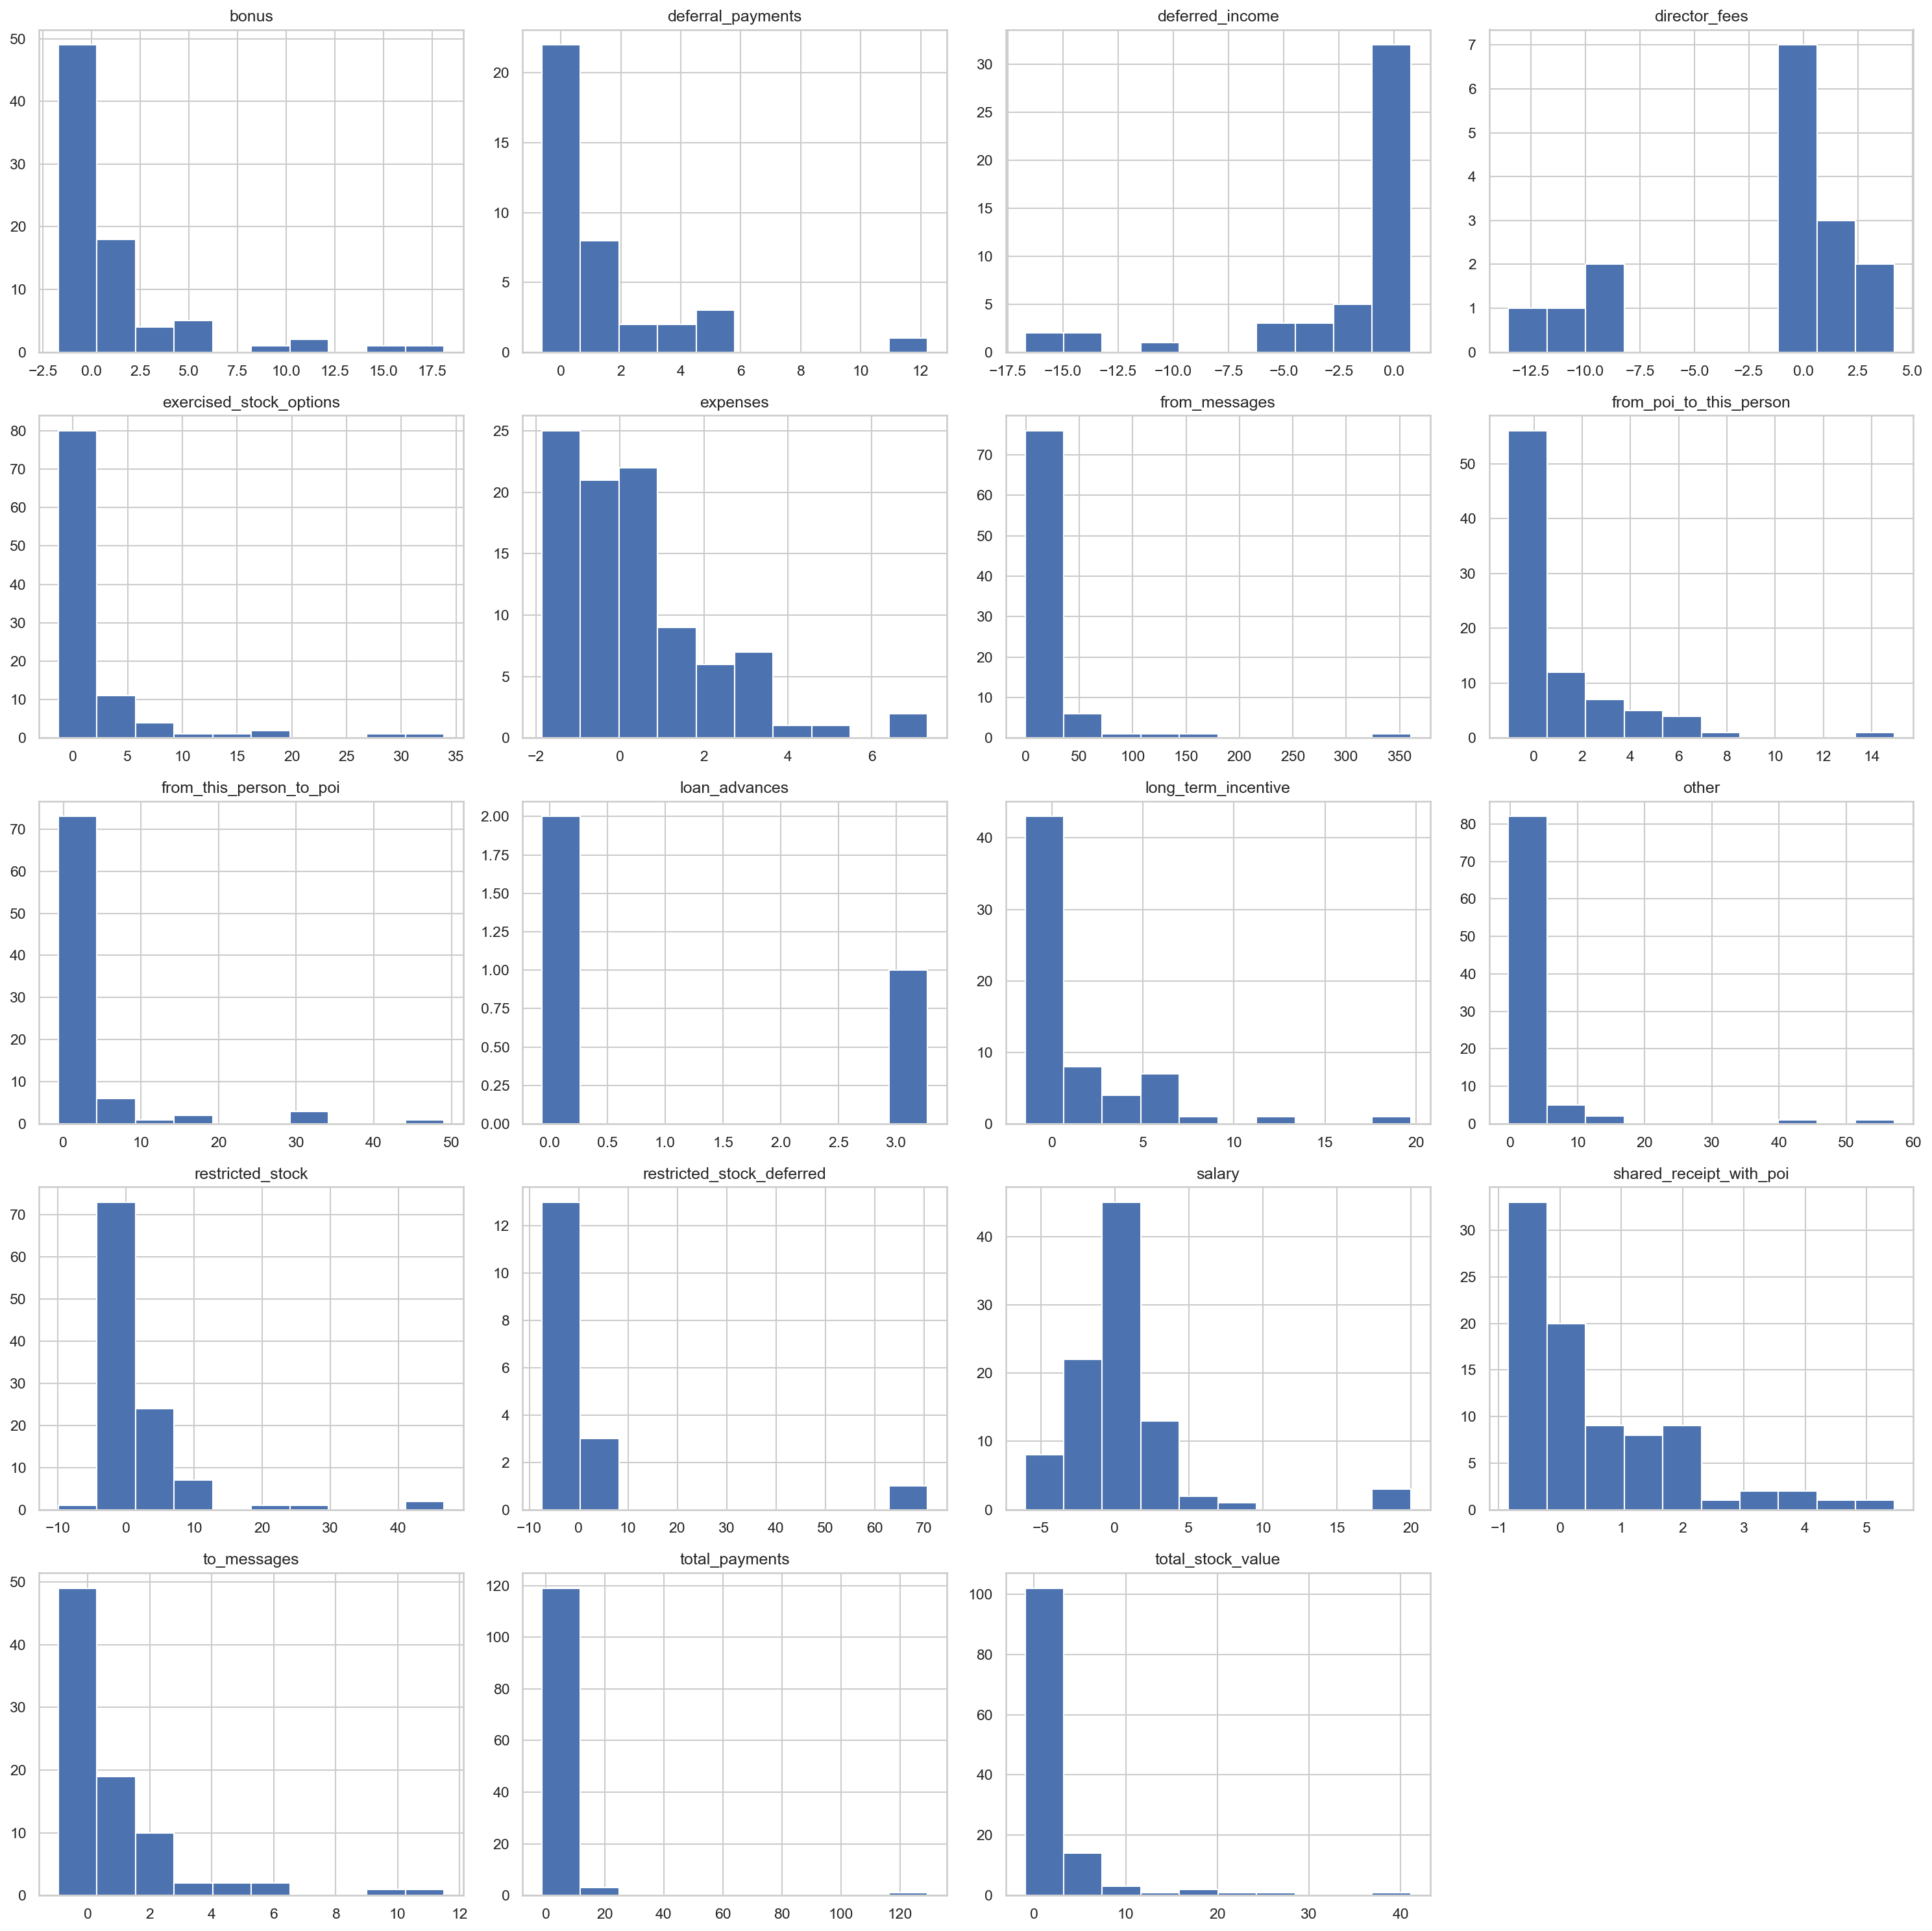

In [69]:
from sklearn.preprocessing import RobustScaler

# experiment with different RobustScaler Quantile Ranges
for value in [0, 1, 5, 10, 15, 20, 25, 30, 35]:
    q_range = (value, 100 - value)
    scaler = RobustScaler(quantile_range=q_range)
    scaled_discovery_df = pd.DataFrame(
        scaler.fit_transform(discovery_df), columns=discovery_df.columns
    )
    scaled_discovery_df = scaled_discovery_df.drop(
        ["TOTAL", "THE TRAVEL AGENCY IN THE PARK"], errors="ignore", axis=0
    )

    scaled_discovery_df.loc[
        :, ~scaled_discovery_df.columns.isin(["poi", "email_address"])
    ].hist(figsize=(20, 20))

    X, y = (
        scaled_discovery_df.loc[:, ~scaled_discovery_df.columns.isin(["poi"])],
        scaled_discovery_df["poi"],
    )
    X = X.fillna(0)

    model = KNeighborsClassifier()

    # create a pipeline that scales the model
    pipeline = Pipeline(steps=[("s", scaler), ("m", model)])
    cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=3, random_state=RANDOM_STATE)
    scores = (
        cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, error_score="raise")
        * 100
    )

    print(
        "{} Range, Accuracy: {:.2f}%, Standard Deviation: {:.2f}".format(
            q_range, scores.mean(), scores.std()
        )
    )


plt.tight_layout()
plt.show()

# Task 1: Select Features

In [70]:
discovery_df.describe()

bonus  deferral_payments  deferred_income  director_fees  \
count      81.00              38.00            48.00          16.00   
mean  1201773.07          841602.53       -581049.81       89822.88   
std   1441679.44         1289322.63        942076.40       41112.70   
min     70000.00         -102500.00      -3504386.00        3285.00   
25%    425000.00           79644.50       -611209.25       83674.50   
50%    750000.00          221063.50       -151927.00      106164.50   
75%   1200000.00          867211.25        -37926.00      112815.00   
max   8000000.00         6426990.00          -833.00      137864.00   

       email_address  exercised_stock_options  expenses  from_messages  \
count           0.00                   101.00     94.00          86.00   
mean             nan               2959559.26  54192.01         608.79   
std              nan               5499449.60  46108.38        1841.03   
min              nan                  3285.00    148.00          12.00   
25%              nan                506765.00  22479.00          22.75   
50%              nan               1297049.00  46547.50          41.00   
75%              nan               2542813.00  78408.50         145.50   
max              nan              34348384.00 228763.00       14368.00   

       from_poi_to_this_person  from_this_person_to_poi  loan_advances  \
count                    86.00                    86.00           3.00   
mean                     64.90                    41.23    27975000.00   
std                      86.98                   100.07    46382560.03   
min                       0.00                     0.00      400000.00   
25%                      10.00                     1.00     1200000.00   
50%                      35.00                     8.00     2000000.00   
75%                      72.25                    24.75    41762500.00   
max                     528.00                   609.00    81525000.00   

       long_term_incentive       other  restricted_stock  \
count                65.00       91.00            109.00   
mean             746491.20   466410.52        1147424.09   
std              862917.42  1397375.61        2249770.36   
min               69223.00        2.00       -2604490.00   
25%              275000.00     1203.00         252055.00   
50%              422158.00    51587.00         441096.00   
75%              831809.00   331983.00         985032.00   
max             5145434.00 10359729.00       14761694.00   

       restricted_stock_deferred     salary  shared_receipt_with_poi  \
count                      17.00      94.00                    86.00   
mean                   621892.82  284087.54                  1176.47   
std                   3845528.35  177131.12                  1178.32   
min                  -1787380.00     477.00                     2.00   
25%                   -329825.00  211802.00                   249.75   
50%                   -140264.00  258741.00                   740.50   
75%                    -72419.00  308606.50                  1888.25   
max                  15456290.00 1111258.00                  5521.00   

       to_messages  total_payments  total_stock_value  
count        86.00          123.00             125.00  
mean       2073.86      2641805.93         3352073.02  
std        2582.70      9524693.91         6532883.10  
min          57.00          148.00          -44093.00  
25%         541.25       396934.00          494136.00  
50%        1211.00      1101393.00         1095040.00  
75%        2634.75      2087529.50         2606763.00  
max       15149.00    103559793.00        49110078.00

### Step 1: Missing Value Ratio
Remove values with a significant percentage of missing data. Our models can't learn from data that isn't present.

- Any features that were missing from more than 50% individuals were dropped
- Each individual had an Email Address however, each datapoint was coerced to a numeric value which resulted in a NaN value for Email Address strings. Also, in this instance, the email_address feature was also irrelevant for statistical modeling.
- 'Other' was dropped because it was unclear what that feature encompasses


In [71]:
# define 'NaN' strings as numpy NaNs
discovery_df[discovery_df == "NaN"] = np.nan

# sort the features by the % NaN values for the feature
pct_missing_values_df = pd.DataFrame(
    data=((discovery_df.isna().sum() / len(discovery_df.index)) * 100),
    columns=["% Missing Values"],
)

# Set the index name to "Feature"
pct_missing_values_df = pct_missing_values_df.rename_axis("Feature")
# sort the features by % Missing Values
pct_missing_values_df.sort_values(by="% Missing Values", inplace=True)
display("Features and their % Missing Values", pct_missing_values_df)

# drop irrelevant features
pct_missing_values_df = pct_missing_values_df.drop(
    ["email_address", "other"], axis=0, errors="ignore"
)

# save the features that are missing less than 50% of their data
pct_missing_values_df = pct_missing_values_df[
    (pct_missing_values_df["% Missing Values"] < 50)
]
cols_with_values = list(pct_missing_values_df.index)

display("Features to keep", pct_missing_values_df)

'Features and their % Missing Values'

% Missing Values
Feature                                    
poi                                    0.00
total_stock_value                     13.19
total_payments                        14.58
restricted_stock                      24.31
exercised_stock_options               29.86
salary                                34.72
expenses                              34.72
other                                 36.81
to_messages                           40.28
shared_receipt_with_poi               40.28
from_messages                         40.28
from_poi_to_this_person               40.28
from_this_person_to_poi               40.28
bonus                                 43.75
long_term_incentive                   54.86
deferred_income                       66.67
deferral_payments                     73.61
restricted_stock_deferred             88.19
director_fees                         88.89
loan_advances                         97.92
email_address                        100.00

'Features to keep'

% Missing Values
Feature                                  
poi                                  0.00
total_stock_value                   13.19
total_payments                      14.58
restricted_stock                    24.31
exercised_stock_options             29.86
salary                              34.72
expenses                            34.72
to_messages                         40.28
shared_receipt_with_poi             40.28
from_messages                       40.28
from_poi_to_this_person             40.28
from_this_person_to_poi             40.28
bonus                               43.75

In [72]:
# perform a statistical summary on the features we're keeping thus far
discovery_df[cols_with_values].describe()

total_stock_value  total_payments  restricted_stock  \
count             125.00          123.00            109.00   
mean          3352073.02      2641805.93        1147424.09   
std           6532883.10      9524693.91        2249770.36   
min            -44093.00          148.00       -2604490.00   
25%            494136.00       396934.00         252055.00   
50%           1095040.00      1101393.00         441096.00   
75%           2606763.00      2087529.50         985032.00   
max          49110078.00    103559793.00       14761694.00   

       exercised_stock_options     salary  expenses  to_messages  \
count                   101.00      94.00     94.00        86.00   
mean                2959559.26  284087.54  54192.01      2073.86   
std                 5499449.60  177131.12  46108.38      2582.70   
min                    3285.00     477.00    148.00        57.00   
25%                  506765.00  211802.00  22479.00       541.25   
50%                 1297049.00  258741.00  46547.50      1211.00   
75%                 2542813.00  308606.50  78408.50      2634.75   
max                34348384.00 1111258.00 228763.00     15149.00   

       shared_receipt_with_poi  from_messages  from_poi_to_this_person  \
count                    86.00          86.00                    86.00   
mean                   1176.47         608.79                    64.90   
std                    1178.32        1841.03                    86.98   
min                       2.00          12.00                     0.00   
25%                     249.75          22.75                    10.00   
50%                     740.50          41.00                    35.00   
75%                    1888.25         145.50                    72.25   
max                    5521.00       14368.00                   528.00   

       from_this_person_to_poi      bonus  
count                    86.00      81.00  
mean                     41.23 1201773.07  
std                     100.07 1441679.44  
min                       0.00   70000.00  
25%                       1.00  425000.00  
50%                       8.00  750000.00  
75%                      24.75 1200000.00  
max                     609.00 8000000.00

In [73]:
# check which sample holds the max value for the remaining features to ensure we don't still have the TOTAL as a sample
display(
    "Validate Max Values",
    discovery_df[[c for c in cols_with_values if c != "poi"]].idxmax(),
)

# if we haven't already, remove the "TOTAL" POI which is an outlier because it's an aggregate value
discovery_df = discovery_df[cols_with_values].drop("TOTAL", errors="ignore")

# re-validate that we've removed aggregates and non-POIs
display(
    "Re-Validate Max Values",
    discovery_df[[c for c in cols_with_values if c != "poi"]].idxmax(),
)

'Validate Max Values'

total_stock_value                LAY KENNETH L
total_payments                   LAY KENNETH L
restricted_stock                 LAY KENNETH L
exercised_stock_options          LAY KENNETH L
salary                      SKILLING JEFFREY K
expenses                      MCCLELLAN GEORGE
to_messages                  SHAPIRO RICHARD S
shared_receipt_with_poi       BELDEN TIMOTHY N
from_messages              KAMINSKI WINCENTY J
from_poi_to_this_person        LAVORATO JOHN J
from_this_person_to_poi       DELAINEY DAVID W
bonus                          LAVORATO JOHN J
dtype: object

'Re-Validate Max Values'

total_stock_value                LAY KENNETH L
total_payments                   LAY KENNETH L
restricted_stock                 LAY KENNETH L
exercised_stock_options          LAY KENNETH L
salary                      SKILLING JEFFREY K
expenses                      MCCLELLAN GEORGE
to_messages                  SHAPIRO RICHARD S
shared_receipt_with_poi       BELDEN TIMOTHY N
from_messages              KAMINSKI WINCENTY J
from_poi_to_this_person        LAVORATO JOHN J
from_this_person_to_poi       DELAINEY DAVID W
bonus                          LAVORATO JOHN J
dtype: object

### Step 2: Low Variance
Features with a lower amount of variance relative to other features were removed. We're arbitrarily filtering down to 7 features with a significant amount of variance. The thought behind this is that our models can't learn as much if the samples are too similar. 

In [74]:
# inspect the variance across features
feature_variance = discovery_df[cols_with_values].var().sort_values()
display("Variance Across Remaining Features", feature_variance)

high_variance_features = list(feature_variance[-7:].index)
display(
    "7 Features With Significant Variance", feature_variance[high_variance_features]
)

'Variance Across Remaining Features'

poi                                    0.11
from_poi_to_this_person             7565.39
from_this_person_to_poi            10014.63
shared_receipt_with_poi          1388432.46
from_messages                    3389406.00
to_messages                      6670344.36
expenses                      2125982471.43
salary                       31375432034.87
bonus                      2078439602903.44
restricted_stock           5061466658800.40
exercised_stock_options   30243945891878.36
total_stock_value         42678561561688.52
total_payments            90719794012368.80
dtype: float64

'7 Features With Significant Variance'

expenses                      2125982471.43
salary                       31375432034.87
bonus                      2078439602903.44
restricted_stock           5061466658800.40
exercised_stock_options   30243945891878.36
total_stock_value         42678561561688.52
total_payments            90719794012368.80
dtype: float64

### Step 3: High Feature Correlation

Remove features that are highly correlated because having the same trends across multiple trends doesn't tell our model anything useful and it results in longer fit and prediction processes. Features that are highly correlated to many other features can serve as a stand-in for those features. Features with a correlation greater than or equal to 0.5 were considered to have High Correlation.

Observations
- The `exercised_stock_options` feature has the highest correlation to the `POI` feature, and it can serve as a stand in for the 5 other features it shares a high correlation with.
- Since the `exercised_stock_options` is highly correlated with other features, we'll choose 2 additional features with low Mean Correlation values so that we better represent the larger feature set.
    - Of the remaining features, `expenses` feature has the lowest mean correlation between features, so that seems like a good choice for a highly independent variable. 
    - `bonus` has a moderately high correlation with `POI` so that feels like a good choice to supplement the other feature that's highly-correlated with POI.

Conclusion

We've narrowed are features down to `exercised_stock_options`, `expenses`, `bonus`. We'll revisit list if this combination of features doesn't provide viable models.



In [75]:
# inspect the correlation between high variance features
feature_corr_df = discovery_df[high_variance_features + ["poi"]].corr()

display("General Feature Correlation", feature_corr_df)

# values with high correlation to POI
display(
    "Features With High Correlation to 'POI' Feature",
    feature_corr_df.poi.apply(abs).sort_values(ascending=False),
)

# features with correlation greater than or equal to 0.5. ignore features with a correlation of 1, because that represents the features correlation with itself.
high_corr_filter = (abs(feature_corr_df) >= 0.5) & (feature_corr_df != 1)
low_corr_filter = abs(feature_corr_df) < 0.5


display("Features With High Correlation", feature_corr_df[high_corr_filter].fillna("-"))
display("Features With Low Correlation", feature_corr_df[low_corr_filter].fillna("-"))


display(
    "# Features With High Correlation To Feature",
    feature_corr_df[high_corr_filter]
    .agg(
        ["count", "mean"],
        axis="columns",
    )
    .sort_values("count", ascending=False),
)
display(
    "# Features With Low Correlation To Feature",
    feature_corr_df[low_corr_filter]
    .agg(
        ["count", "mean"],
        axis="columns",
    )
    .sort_values("count", ascending=False),
)

low_corr_features = [
    "exercised_stock_options",
    "shared_receipt_with_poi",
    "from_messages",
]

'General Feature Correlation'

expenses  salary  bonus  restricted_stock  \
expenses                     1.00    0.15   0.03              0.04   
salary                       0.15    1.00   0.52              0.55   
bonus                        0.03    0.52   1.00              0.38   
restricted_stock             0.04    0.55   0.38              1.00   
exercised_stock_options      0.02    0.61   0.51              0.69   
total_stock_value            0.03    0.61   0.51              0.86   
total_payments               0.11    0.58   0.57              0.60   
poi                          0.06    0.26   0.30              0.22   

                         exercised_stock_options  total_stock_value  \
expenses                                    0.02               0.03   
salary                                      0.61               0.61   
bonus                                       0.51               0.51   
restricted_stock                            0.69               0.86   
exercised_stock_options                     1.00               0.96   
total_stock_value                           0.96               1.00   
total_payments                              0.59               0.67   
poi                                         0.50               0.37   

                         total_payments  poi  
expenses                           0.11 0.06  
salary                             0.58 0.26  
bonus                              0.57 0.30  
restricted_stock                   0.60 0.22  
exercised_stock_options            0.59 0.50  
total_stock_value                  0.67 0.37  
total_payments                     1.00 0.23  
poi                                0.23 1.00

"Features With High Correlation to 'POI' Feature"

poi                       1.00
exercised_stock_options   0.50
total_stock_value         0.37
bonus                     0.30
salary                    0.26
total_payments            0.23
restricted_stock          0.22
expenses                  0.06
Name: poi, dtype: float64

'Features With High Correlation'

expenses salary bonus restricted_stock  \
expenses                       -      -     -                -   
salary                         -      -  0.52             0.55   
bonus                          -   0.52     -                -   
restricted_stock               -   0.55     -                -   
exercised_stock_options        -   0.61  0.51             0.69   
total_stock_value              -   0.61  0.51             0.86   
total_payments                 -   0.58  0.57             0.60   
poi                            -      -     -                -   

                        exercised_stock_options total_stock_value  \
expenses                                      -                 -   
salary                                     0.61              0.61   
bonus                                      0.51              0.51   
restricted_stock                           0.69              0.86   
exercised_stock_options                       -              0.96   
total_stock_value                          0.96                 -   
total_payments                             0.59              0.67   
poi                                        0.50                 -   

                        total_payments  poi  
expenses                             -    -  
salary                            0.58    -  
bonus                             0.57    -  
restricted_stock                  0.60    -  
exercised_stock_options           0.59 0.50  
total_stock_value                 0.67    -  
total_payments                       -    -  
poi                                  -    -

'Features With Low Correlation'

expenses salary bonus restricted_stock  \
expenses                       -   0.15  0.03             0.04   
salary                      0.15      -     -                -   
bonus                       0.03      -     -             0.38   
restricted_stock            0.04      -  0.38                -   
exercised_stock_options     0.02      -     -                -   
total_stock_value           0.03      -     -                -   
total_payments              0.11      -     -                -   
poi                         0.06   0.26  0.30             0.22   

                        exercised_stock_options total_stock_value  \
expenses                                   0.02              0.03   
salary                                        -                 -   
bonus                                         -                 -   
restricted_stock                              -                 -   
exercised_stock_options                       -                 -   
total_stock_value                             -                 -   
total_payments                                -                 -   
poi                                           -              0.37   

                        total_payments  poi  
expenses                          0.11 0.06  
salary                               - 0.26  
bonus                                - 0.30  
restricted_stock                     - 0.22  
exercised_stock_options              -    -  
total_stock_value                    - 0.37  
total_payments                       - 0.23  
poi                               0.23    -

'# Features With High Correlation To Feature'

count  mean
exercised_stock_options   6.00  0.64
salary                    5.00  0.58
total_stock_value         5.00  0.72
total_payments            5.00  0.60
bonus                     4.00  0.53
restricted_stock          4.00  0.67
poi                       1.00  0.50
expenses                  0.00   nan

'# Features With Low Correlation To Feature'

count  mean
expenses                  7.00  0.06
poi                       6.00  0.24
bonus                     3.00  0.24
restricted_stock          3.00  0.21
salary                    2.00  0.21
total_stock_value         2.00  0.20
total_payments            2.00  0.17
exercised_stock_options   1.00  0.02

### Recursive Feature Elimination (RFE) with Logistic Regression Classifier
Using LogisticRegression classifier with RFE across all 21 features to both validate our remaining features and to view features that are more or most relevant in predicting POI.

Observations
- None of our selected features (exercised_stock_options, expenses, bonus) were selected by the estimator. In fact, all of our selections ranked poorly. We'll need to run RFE with another classifier to validate our findings. If our selected features don't prove useful, we can consider using features that ranked with this estimator.

In [76]:
estimator = LogisticRegression(random_state=RANDOM_STATE)

# create a RFE that will using Logistic Regression to select the Top 5 features based on importance/relevance
rfe = RFE(estimator, n_features_to_select=5)

rfe_df = discovery_df.fillna(0)
X, y = rfe_df.loc[:, ~rfe_df.columns.isin(["poi"])], rfe_df["poi"].astype(int)
rfe = rfe.fit(X, y)

display(
    "Features",
    list(X.columns),
    "Feature Ranking",
    rfe.ranking_,
    "Feature Relevance",
    rfe.support_,
)

# merge our ranking scores with feature names
feature_ranking_df = pd.DataFrame(zip(X.columns, rfe.ranking_)).sort_values(1)
display("Feature Ranking", feature_ranking_df)

'Features'

['total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'salary',
 'expenses',
 'to_messages',
 'shared_receipt_with_poi',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'bonus']

'Feature Ranking'

array([1, 8, 1, 2, 6, 5, 1, 1, 4, 3, 1, 7])

'Feature Relevance'

array([ True, False,  True, False, False, False,  True,  True, False,
       False,  True, False])

'Feature Ranking'

0  1
0         total_stock_value  1
2          restricted_stock  1
6               to_messages  1
7   shared_receipt_with_poi  1
10  from_this_person_to_poi  1
3   exercised_stock_options  2
9   from_poi_to_this_person  3
8             from_messages  4
5                  expenses  5
4                    salary  6
11                    bonus  7
1            total_payments  8

#### Recursive Feature Elimination (RFE) with Random Forest Classifier
Using RandomForest ensemble classifier with RFE across all 21 features to both validate our remaining features and to view features that are more or most relevant in predicting POI.

Observations
- Our selected features (exercised_stock_options, expenses, bonus) fared moderately better using this estimator.
- Total Stock Value, Restricted Stock, and from_this_person_to_poi scored high with both estimators, so those seem like strong candidates to also explore

Conclusion
- For now I'm satisfied with the features I've selected because of the selection rationale outlined in the steps above. However, I will consider substituting the features that were selected by the RFE Estimators if the models don't produce a desirable F1 Score.

In [77]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_depth=2, random_state=RANDOM_STATE)

# create a RFE that will using RandomForestClassifier to select the Top 5 features based on importance/relevance
rfe = RFE(estimator, n_features_to_select=5)

rfe_df = discovery_df.fillna(0)
X, y = rfe_df.loc[:, ~rfe_df.columns.isin(["poi"])], rfe_df["poi"].astype(int)
rfe = rfe.fit(X, y)

display(
    "Features",
    list(X.columns),
    "Feature Ranking",
    rfe.ranking_,
    "Feature Relevance",
    rfe.support_,
)

# merge our ranking scores with feature names
feature_ranking_df = pd.DataFrame(zip(X.columns, rfe.ranking_)).sort_values(1)
display("Feature Ranking", feature_ranking_df)

'Features'

['total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'salary',
 'expenses',
 'to_messages',
 'shared_receipt_with_poi',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'bonus']

'Feature Ranking'

array([1, 6, 1, 8, 5, 2, 7, 3, 4, 1, 1, 1])

'Feature Relevance'

array([ True, False,  True, False, False, False, False, False, False,
        True,  True,  True])

'Feature Ranking'

0  1
0         total_stock_value  1
2          restricted_stock  1
9   from_poi_to_this_person  1
10  from_this_person_to_poi  1
11                    bonus  1
5                  expenses  2
7   shared_receipt_with_poi  3
8             from_messages  4
4                    salary  5
1            total_payments  6
6               to_messages  7
3   exercised_stock_options  8

In [78]:
features_list = [
    "poi",
    "bonus",
    "exercised_stock_options",
    "expenses",
]

# Task 2: Remove outliers

- We're removing the 'TOTAL' sample because it's an outlier in the data and represents an aggregate value
- 'THE TRAVEL AGENCY IN THE PARK' doesn't represent a person, but rather an entity
- The remainder of the outliers across the features are actual individuals that for whatever reason have a disproportionately large value. If needed, we'll experiment with reducing these imbalances with feature scaling.
- There's a significant class imbalance for the POI feature

In [79]:
df = df.drop(["TOTAL", "THE TRAVEL AGENCY IN THE PARK"], errors="ignore", axis=0)
df = df.fillna(0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5c1843610>,
      dtype=object)

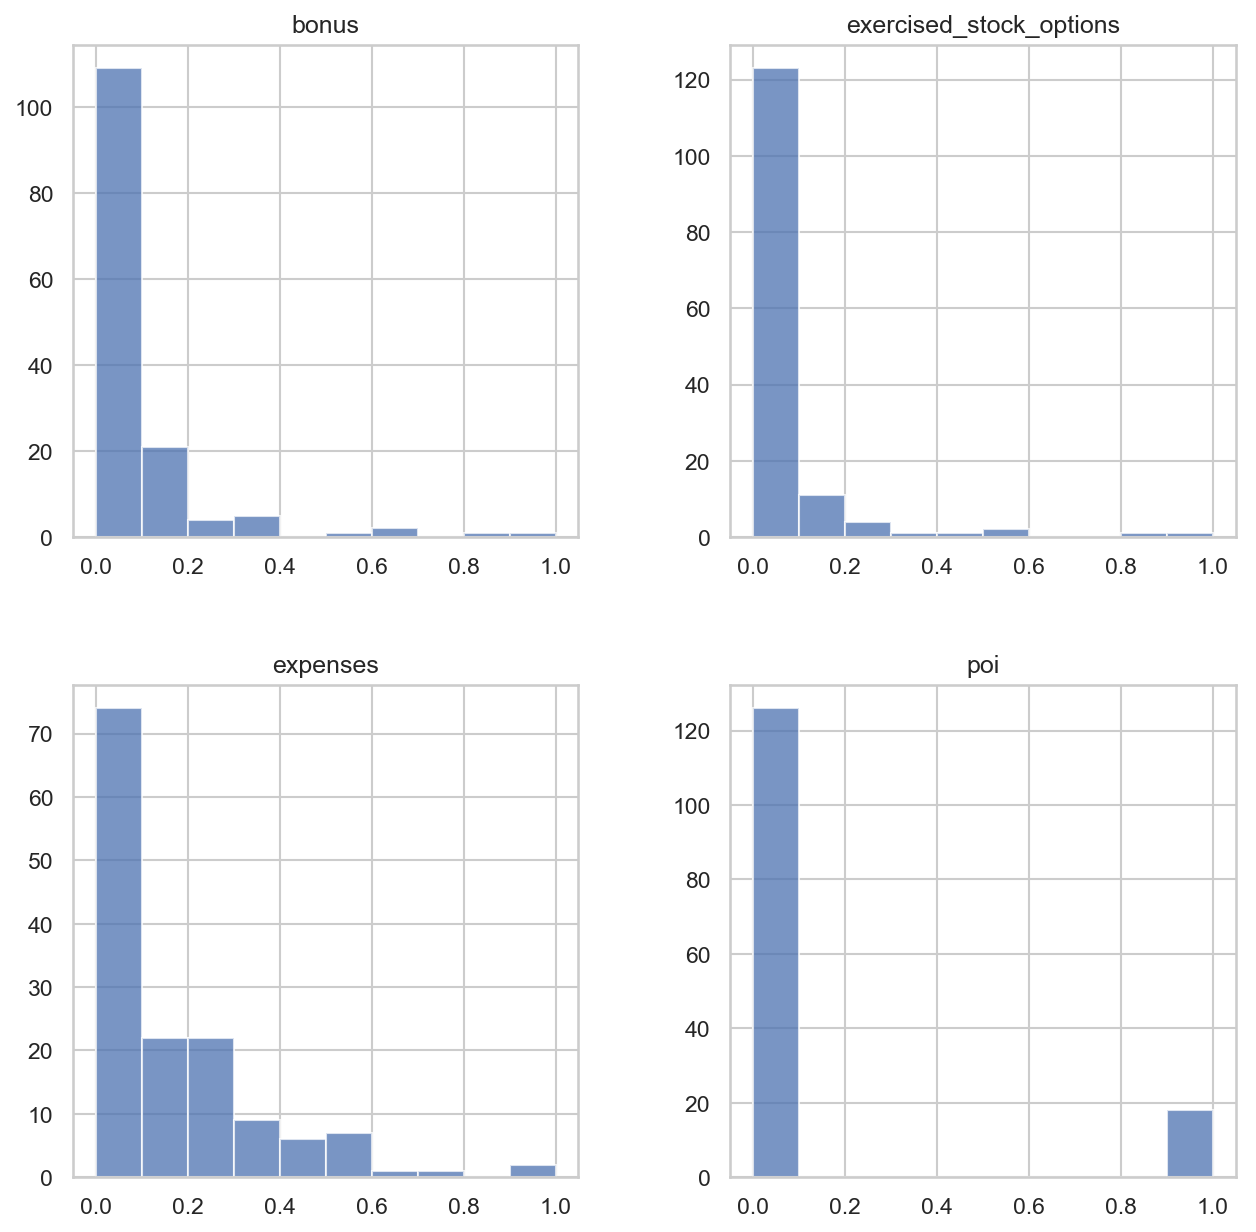

In [80]:
# histogram showing the distribution of selected data features (excluding POI)
pd.DataFrame(
    MinMaxScaler().fit_transform(df[features_list]), columns=df[features_list].columns
).hist(alpha=0.75, figsize=(10, 10))

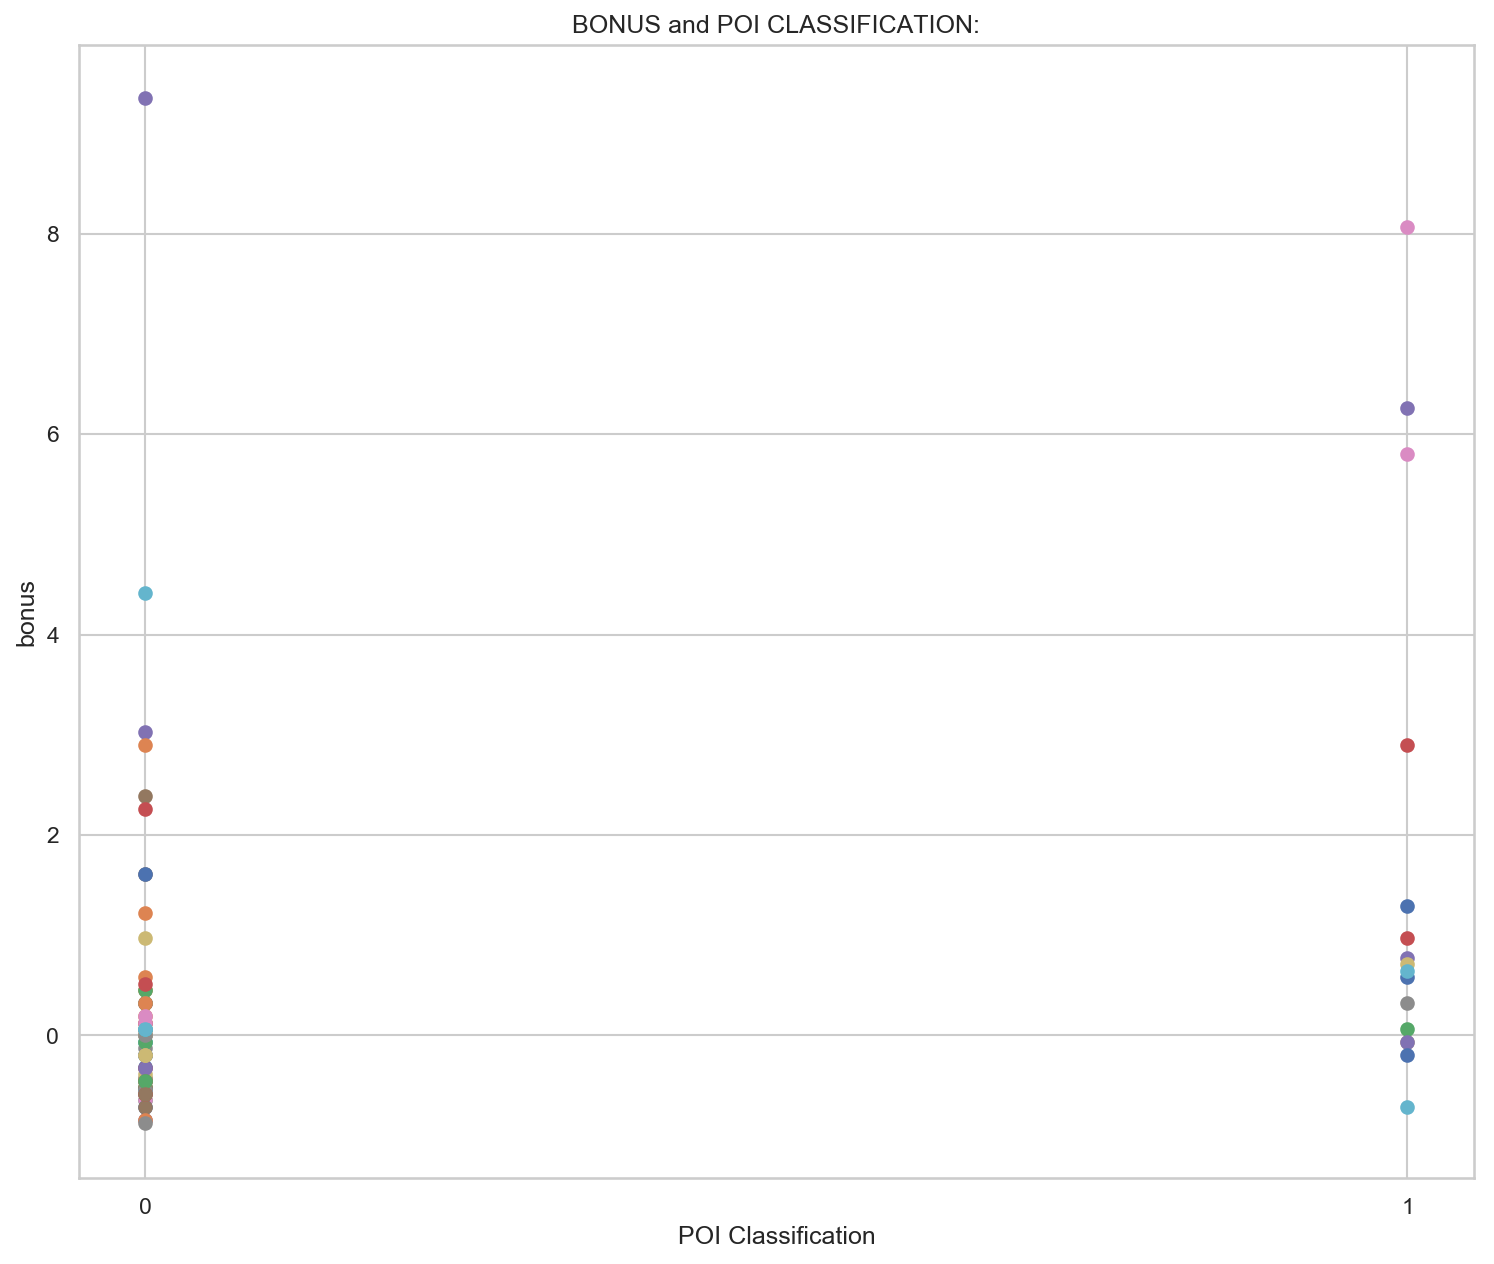

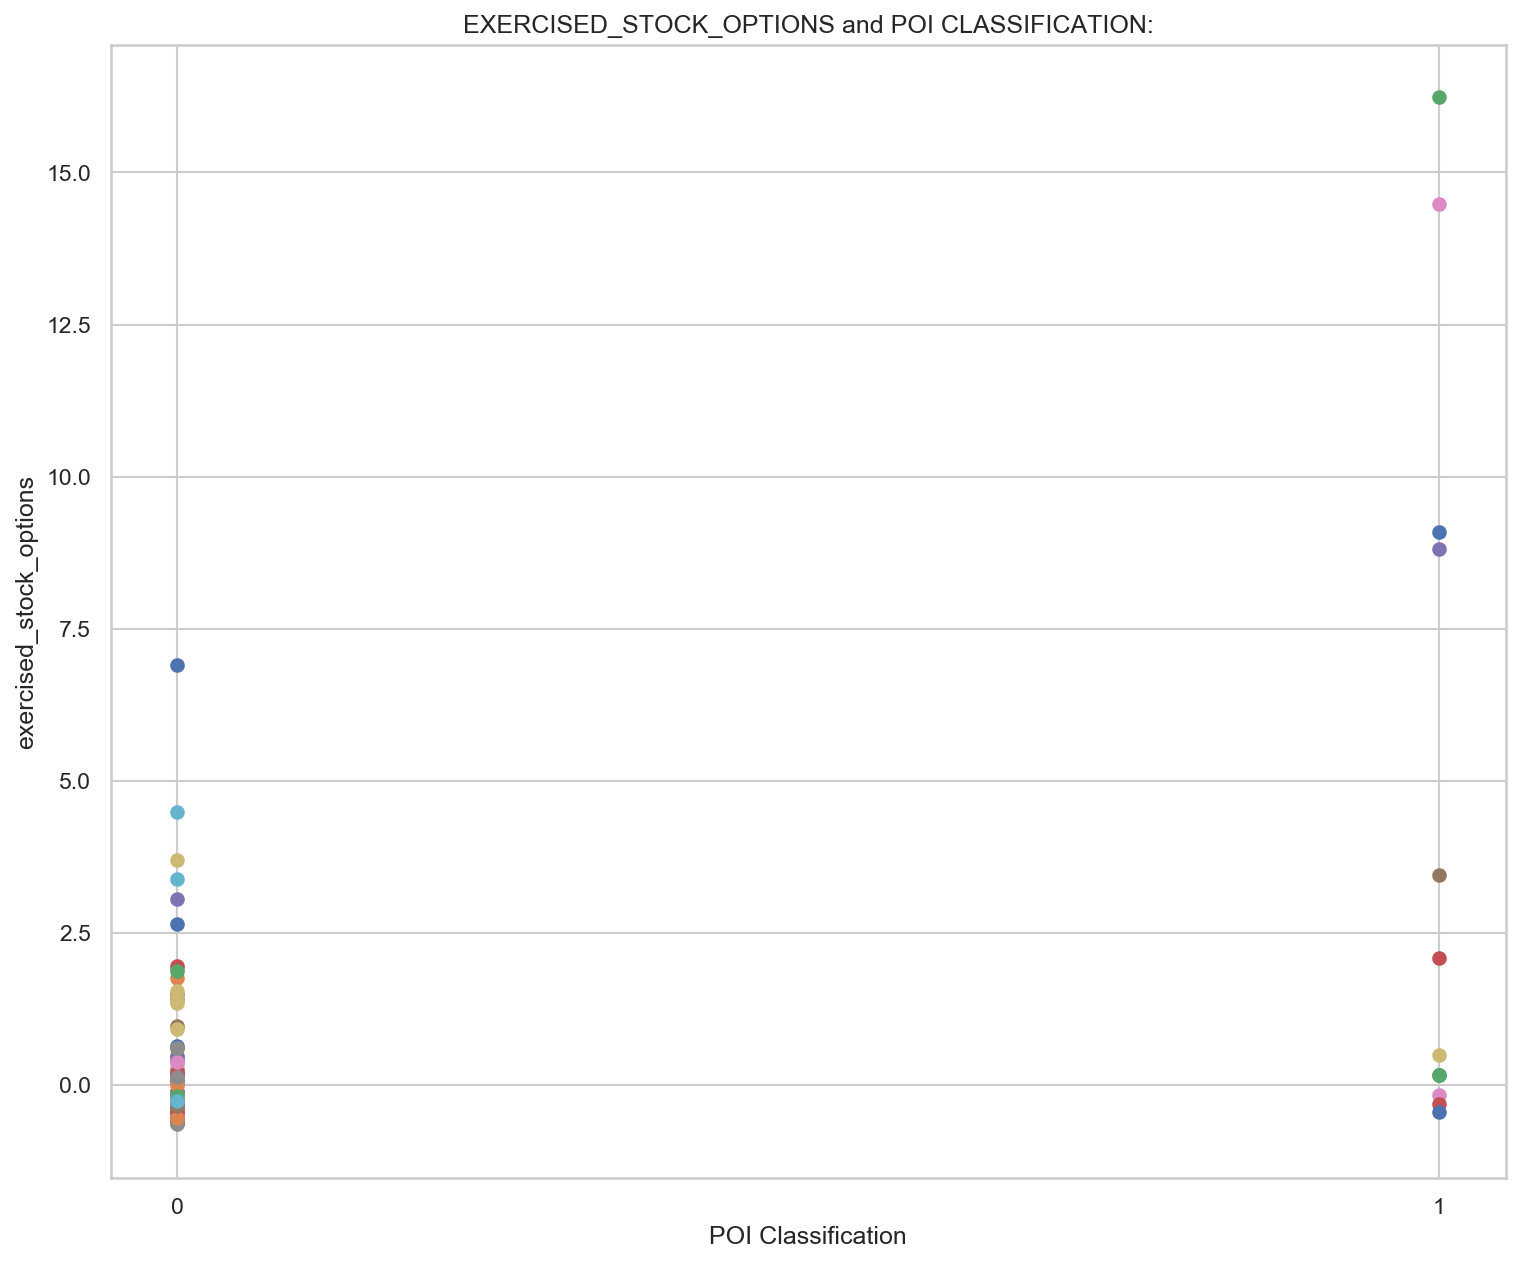

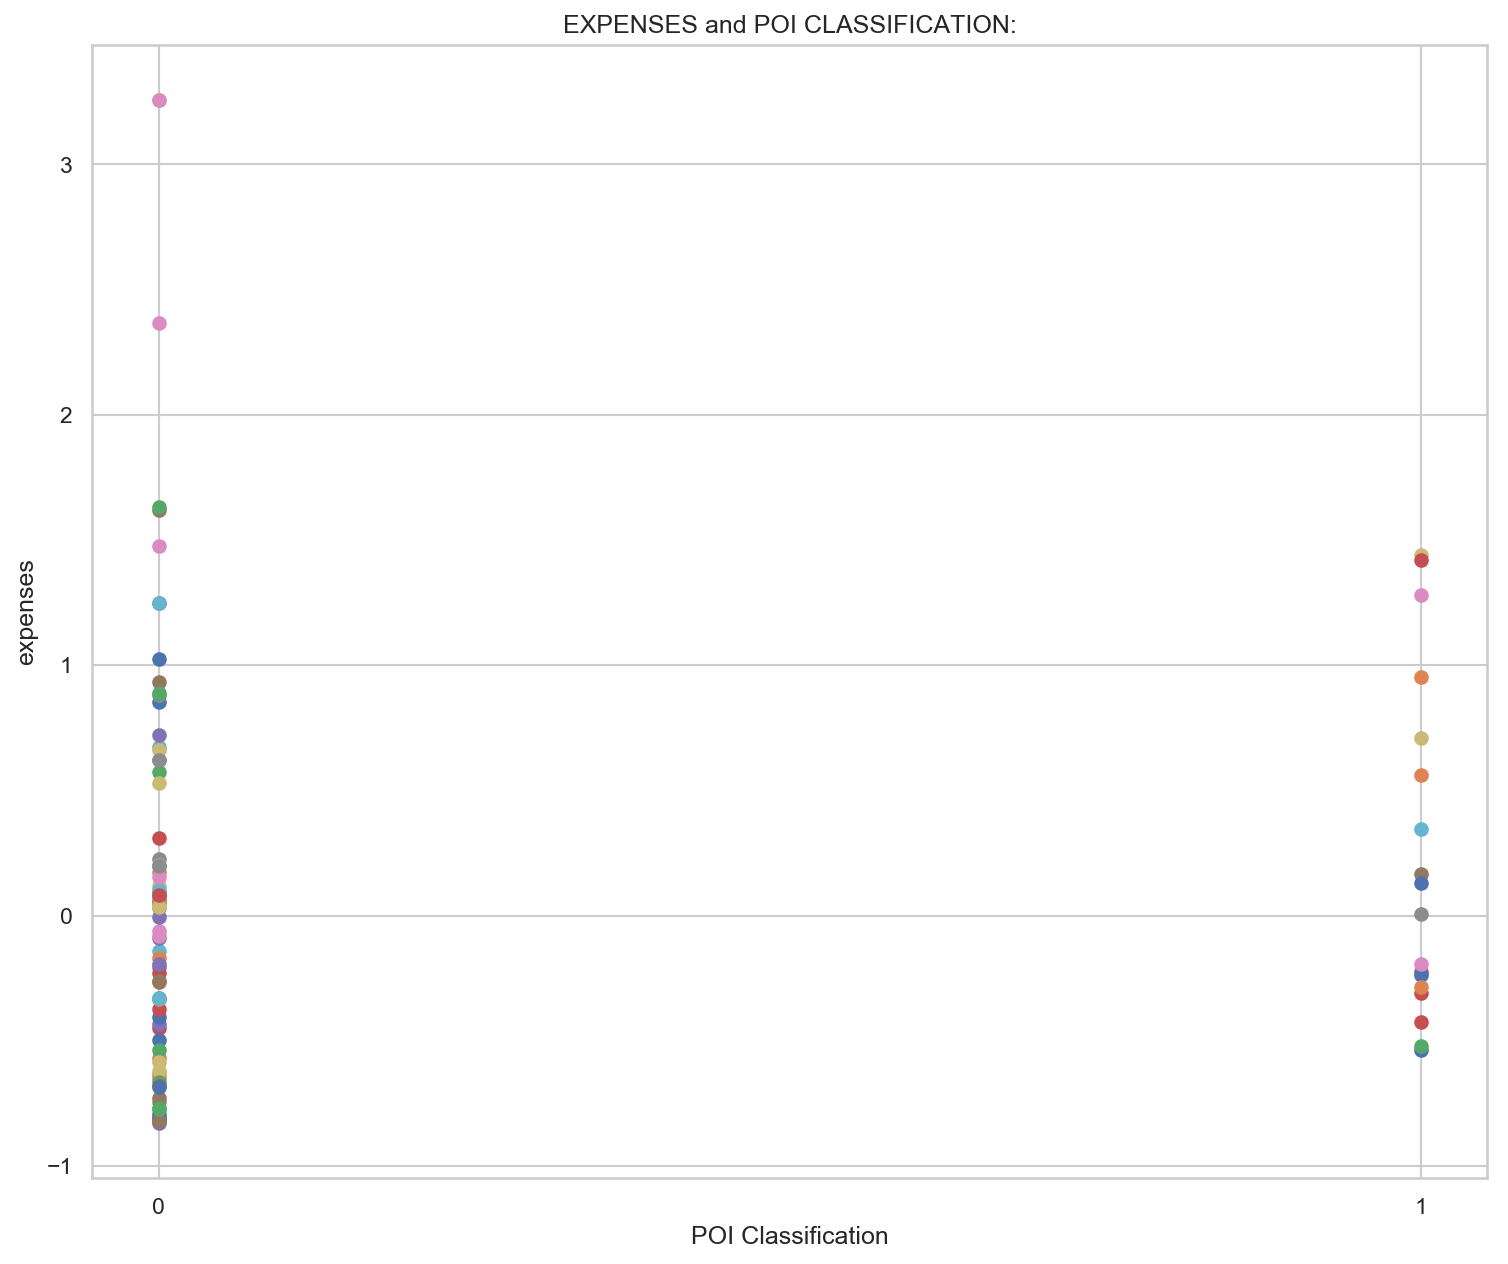

In [81]:
# summarize selected features (except for POI)
df[features_list].describe()

# plot the POI class distribution for each feature
for feature in features_list[1:]:
    plotData(
        df.to_dict(orient="index"),
        features=[
            "poi",
            feature,
        ],
        xLabel="POI Classification",
        yLabel=feature,
        scaler=RobustScaler(),
    )

# Task 3: Create a new feature
Creating a `pct_poi_messages` feature that calculates the percentage of a sample's total messages that are to or from a POI.

In [82]:
df["pct_poi_messages"] = df.apply(calculate_pct_poi_msgs, axis=1)

In [83]:
### Store to my_dataset for easy export below.
features, labels, my_dataset = create_features(df, features_list)

# Task 4: Try a variety of classifiers
Note: The RandomForest classifiers are commented out below because they take a signifcant amount of time to iterate through each set of parameter options.

In [84]:
# construct a PCA to use as a pipeline step
pca = PCA()

models = [
    {
        "title": "GaussianNB (PCA)",
        "pipeline": Pipeline(
            steps=[
                ("pca", pca),
                ("clf", GaussianNB()),
            ]
        ),
        "param_grid": {"pca__n_components": [1]},
    },
    {
        "title": "GaussianNB (StandardScaler + PCA)",
        "pipeline": Pipeline(
            steps=[("scaler", StandardScaler()), ("pca", pca), ("clf", GaussianNB())]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
        },
    },
    {
        "title": "GaussianNB (MinMaxScaler + PCA)",
        "pipeline": Pipeline(
            steps=[("scaler", MinMaxScaler()), ("pca", pca), ("clf", GaussianNB())]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
        },
    },
    {
        "title": "DecisionTreeClassifier (PCA)",
        "pipeline": Pipeline(
            steps=[
                ("pca", pca),
                ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__criterion": ["gini", "entropy"],
            "clf__splitter": ["best", "random"],
            "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40],
        },
    },
    {
        "title": "DecisionTreeClassifier (StandardScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("pca", pca),
                ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__criterion": ["gini", "entropy"],
            "clf__splitter": ["best", "random"],
            "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40],
        },
    },
    {
        "title": "DecisionTreeClassifier (MinMaxScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("pca", pca),
                ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__criterion": ["gini", "entropy"],
            "clf__splitter": ["best", "random"],
            "clf__min_samples_split": [2, 4, 6, 8, 10, 20, 30, 40],
        },
    },
    {
        "title": "AdaBoost (PCA)",
        "pipeline": Pipeline(
            steps=[
                ("pca", PCA()),
                ("clf", AdaBoostClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_estimators": [25, 50, 75, 100],
            "clf__algorithm": ["SAMME", "SAMME.R"],
        },
    },
    {
        "title": "AdaBoost (StandardScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("pca", PCA()),
                ("clf", AdaBoostClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_estimators": [25, 50, 75, 100],
            "clf__algorithm": ["SAMME", "SAMME.R"],
        },
    },
    {
        "title": "AdaBoost (MinMaxScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("pca", PCA()),
                ("clf", AdaBoostClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_estimators": [25, 50, 75, 100],
            "clf__algorithm": ["SAMME", "SAMME.R"],
        },
    },
    {
        "title": "KNeighbors (PCA)",
        "pipeline": Pipeline(
            steps=[
                ("pca", PCA()),
                ("clf", KNeighborsClassifier()),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_neighbors": [2, 4, 6, 8],
            "clf__weights": ["uniform", "distance"],
            "clf__algorithm": [
                "ball_tree",
                "kd_tree",
                "brute",
            ],
            "clf__leaf_size": [5, 10],
            "clf__p": [1, 2],
        },
    },
    {
        "title": "KNeighbors (StandardScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("pca", PCA()),
                ("clf", KNeighborsClassifier()),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_neighbors": [2, 4, 6, 8],
            "clf__weights": ["uniform", "distance"],
            "clf__algorithm": [
                "ball_tree",
                "kd_tree",
                "brute",
            ],
            "clf__leaf_size": [5, 10],
            "clf__p": [1, 2],
        },
    },
    {
        "title": "KNeighbors (MinMaxScaler + PCA)",
        "pipeline": Pipeline(
            steps=[
                ("scaler", MinMaxScaler()),
                ("pca", PCA()),
                ("clf", KNeighborsClassifier()),
            ]
        ),
        "param_grid": {
            "pca__n_components": range(1, len(features_list) - 1) + [None],
            "clf__n_neighbors": [2, 4, 6, 8],
            "clf__weights": ["uniform", "distance"],
            "clf__algorithm": [
                "ball_tree",
                "kd_tree",
                "brute",
            ],
            "clf__leaf_size": [5, 10],
            "clf__p": [1, 2],
        },
    },
    # {
    #     "title": "RandomForest (PCA)",
    #     "pipeline": Pipeline(
    #         steps=[
    #             ("pca", PCA()),
    #             ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
    #         ]
    #     ),
    #     "param_grid": {
    #         # "pca__n_components": range(1, len(features_list) - 1) + [None],
    #         "clf__criterion": ["gini", "entropy"],
    #         "clf__n_estimators": [5, 10, 25, 50, 100],
    #         "clf__max_depth": [2, 4, 6, 8, 10, 20],
    #         "clf__min_samples_split": [2, 6, 10, 20, 30],
    #         "clf__class_weight": ["balanced", "balanced_subsample"],
    #     },
    # },
    # {
    #     "title": "RandomForest (StandardScaler + PCA)",
    #     "pipeline": Pipeline(
    #         steps=[
    #             ("scaler", StandardScaler()),
    #             ("pca", PCA()),
    #             ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
    #         ]
    #     ),
    #     "param_grid": {
    #         # "pca__n_components": range(1, len(features_list) - 1) + [None],
    #         "clf__criterion": ["gini", "entropy"],
    #         "clf__n_estimators": [5, 10, 25, 50, 100],
    #         "clf__max_depth": [2, 4, 6, 8, 10, 20],
    #         "clf__min_samples_split": [2, 6, 10, 20, 30],
    #         "clf__class_weight": ["balanced", "balanced_subsample"],
    #     },
    # },
    # {
    #     "title": "RandomForest (MinMaxScaler + PCA)",
    #     "pipeline": Pipeline(
    #         steps=[
    #             ("scaler", MinMaxScaler()),
    #             ("pca", PCA()),
    #             ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
    #         ]
    #     ),
    #     "param_grid": {
    #         # "pca__n_components": range(1, len(features_list) - 1) + [None],
    #         "clf__criterion": ["gini", "entropy"],
    #         "clf__n_estimators": [5, 10, 25, 50, 100],
    #         "clf__max_depth": [2, 4, 6, 8, 10, 20],
    #         "clf__min_samples_split": [2, 6, 10, 20, 30],
    #         "clf__class_weight": ["balanced", "balanced_subsample"],
    #     },
    # },
]

precision    recall  f1-score   support

     NOT POI       0.86      1.00      0.92        12
         POI       0.00      0.00      0.00         2

   micro avg       0.86      0.86      0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14

('GridSearch Best Params', {'pca__n_components': 1, 'clf__algorithm': 'SAMME', 'clf__n_estimators': 25})
              precision    recall  f1-score   support

     NOT POI       0.86      1.00      0.92        12
         POI       0.00      0.00      0.00         2

   micro avg       0.86      0.86      0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14

('GridSearch Best Params', {'pca__n_components': None, 'clf__algorithm': 'SAMME', 'clf__n_estimators': 25})
              precision    recall  f1-score   support

     NOT POI       0.92      0.92      0.92        12
         POI       0.50      0.50     

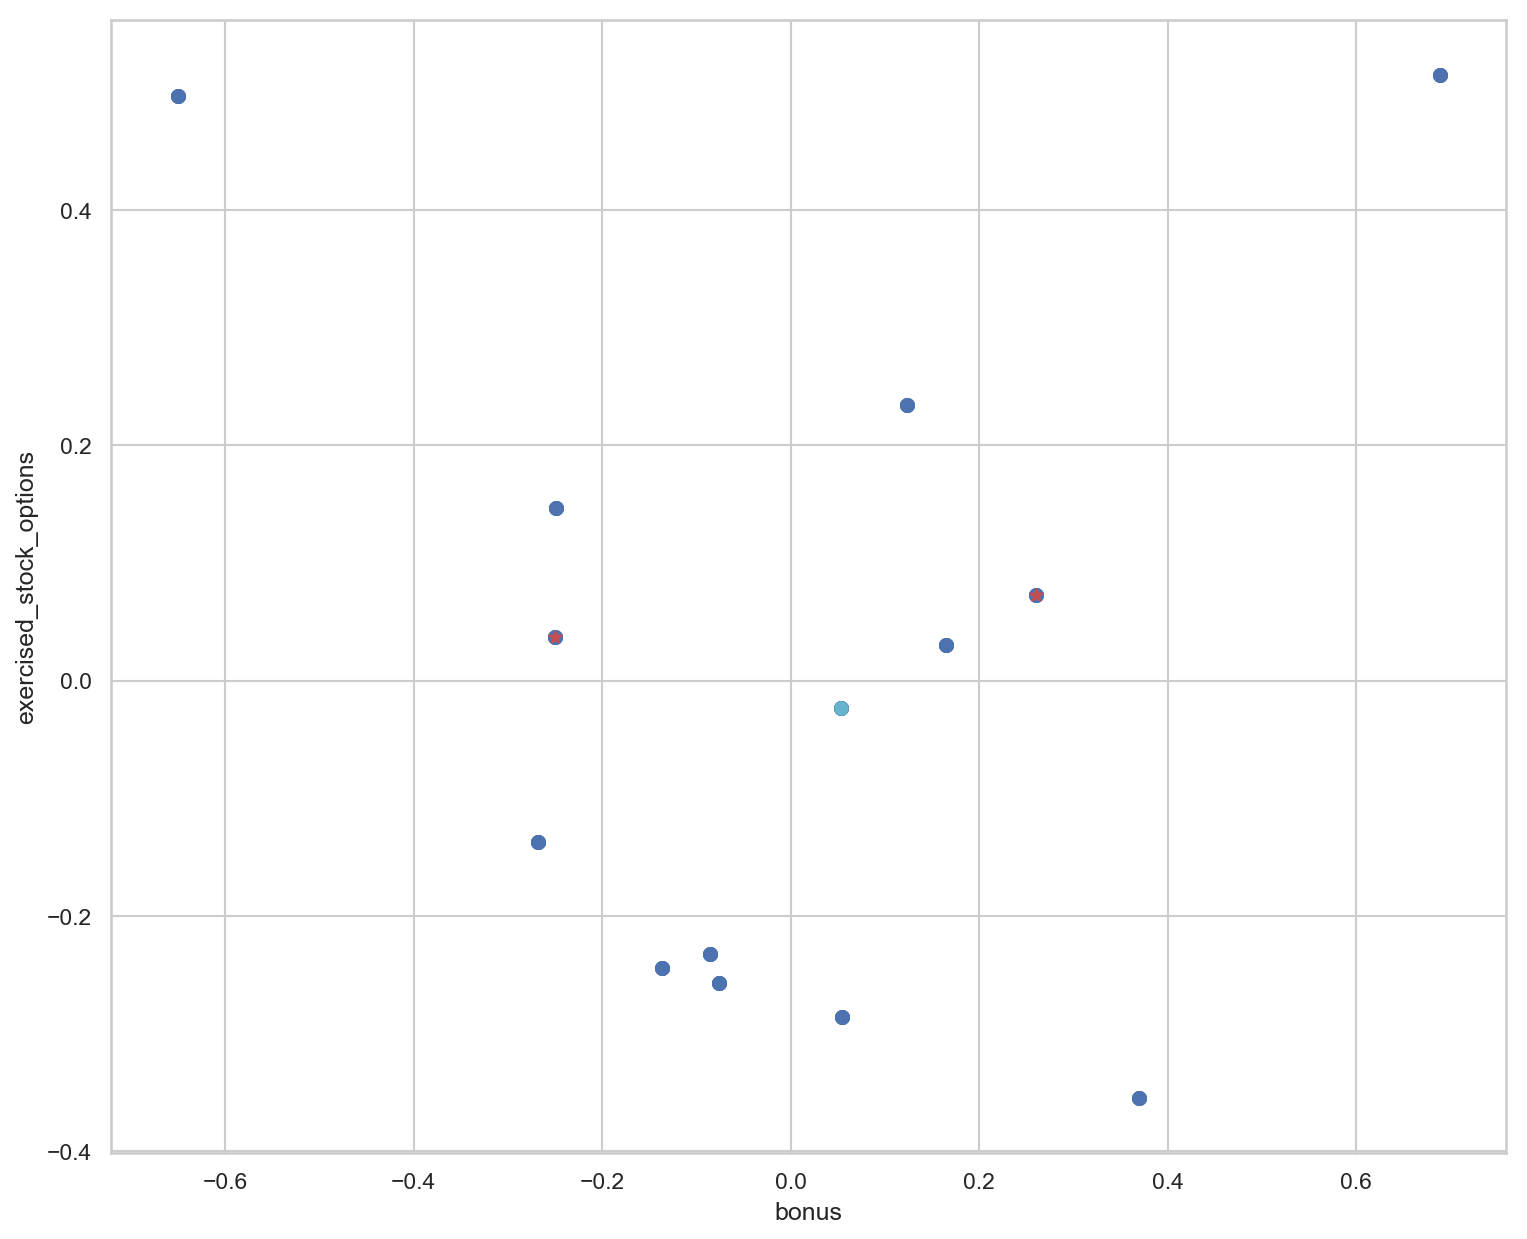

In [85]:
for model in models:
    model_clf = GridSearchCV(
        model.get("pipeline"),
        model.get("param_grid", {}),
        cv=3,
        iid=False,
    )

    ### Task 5: Tune your classifier to achieve better than .3 precision and recall
    validate_classifier(
        clf_name=model.get("title"),
        clf=model_clf,
        features_list=features_list,
        features=features,
        labels=labels,
        folds=FOLDS,
        reports={
            "classification": True,
            "best_estimator": False,
            "best_params": True,
            "confusion_matrix": False,
        },
        random_state=RANDOM_STATE,
    )

# Task 5: Tune your classifier 

We're tuning each model by experimenting with its parameters. We'll narrow down the most effective parameters by monitoring the model's F1 Score, as well as what GridSearchCV consistently determines the best parameters are. Lastly, we'll add and remove pipeline steps until we find an optimal pipeline.

Note: The RandomForest classifiers are commented out above because they take a signifcant amount of time to iterate through each set of parameter options.

In [86]:
# construct a PCA to use as a pipeline step
pca = PCA()

tuned_models = [
    {
        "title": "DecisionTreeClassifier (RobustScaler + PCA) -- Tuned",
        "pipeline": Pipeline(
            steps=[
                ("scaler", RobustScaler()),
                ("pca", pca),
                ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "scaler__quantile_range": [
                (25, 75),
            ],
            "pca__n_components": [2],
            "clf__criterion": ["gini"],
            "clf__splitter": ["random"],
            "clf__min_samples_split": [4],
        },
    },
    {
        "title": "AdaBoost (PCA) -- Tuned",
        "pipeline": Pipeline(
            steps=[
                ("scaler", RobustScaler()),
                ("pca", PCA(random_state=RANDOM_STATE)),
                ("clf", AdaBoostClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "scaler__quantile_range": [
                (25, 75),
            ],
            "pca__n_components": [2],
            "clf__n_estimators": [16],
            "clf__algorithm": ["SAMME"],
            "clf__learning_rate": [1],
        },
    },
    {
        "title": "KNeighbors (PCA) -- Tuned",
        "pipeline": Pipeline(
            steps=[
                ("pca", PCA()),
                ("clf", KNeighborsClassifier()),
            ]
        ),
        "param_grid": {
            "pca__n_components": [2],
            "clf__n_neighbors": [2],
            "clf__weights": ["uniform"],
            "clf__algorithm": ["ball_tree"],
            "clf__leaf_size": [2],
            "clf__p": [1],
        },
    },
    {
        "title": "RandomForest (RobustScaler + PCA) -- Tuned",
        "pipeline": Pipeline(
            steps=[
                ("scaler", RobustScaler()),
                ("pca", PCA()),
                ("clf", RandomForestClassifier(random_state=RANDOM_STATE)),
            ]
        ),
        "param_grid": {
            "pca__n_components": [2],
            "scaler__quantile_range": [(32, 68)],
            "clf__criterion": ["gini"],
            "clf__n_estimators": [20],
            "clf__min_samples_split": [2],
            "clf__class_weight": [None],
        },
    },
]

for model in tuned_models:
    tuned_clf = GridSearchCV(
        model.get("pipeline"),
        model.get("param_grid", {}),
        cv=3,
        iid=False,
    )

    print(model.get("title"))
    test_classifier(
        clf=tuned_clf, dataset=my_dataset, feature_list=features_list, folds=FOLDS
    )

DecisionTreeClassifier (RobustScaler + PCA) -- Tuned
TOTAL PREDICTIONS 140
true_negatives 116
false_negatives 10
true_positives 10
false_positives 4
	Accuracy: 0.90000	Precision: 0.71429	Recall: 0.50000	F1: 0.58824	F2: 0.53191
	Total predictions:  140	True positives:   10	False positives:    4	False negatives:   10	True negatives:  116

AdaBoost (PCA) -- Tuned
TOTAL PREDICTIONS 140
true_negatives 113
false_negatives 10
true_positives 10
false_positives 7
	Accuracy: 0.87857	Precision: 0.58824	Recall: 0.50000	F1: 0.54054	F2: 0.51546
	Total predictions:  140	True positives:   10	False positives:    7	False negatives:   10	True negatives:  113

KNeighbors (PCA) -- Tuned
TOTAL PREDICTIONS 140
true_negatives 118
false_negatives 13
true_positives 7
false_positives 2
	Accuracy: 0.89286	Precision: 0.77778	Recall: 0.35000	F1: 0.48276	F2: 0.39326
	Total predictions:  140	True positives:    7	False positives:    2	False negatives:   13	True negatives:  118

RandomForest (RobustScaler + PCA) -- Tun

# Selected Model and Model Validation

Of the 4 models that we've tuned, all 4 achieved a Precision and Recall above 0.3 for the 10-Fold Cross Validation with a total of 140 samples. The Random Forest ensemble classifier with Robust Scaling and PCA as well as the Decision Tree classifier with Robust Scaling and PCA both achieved an F1 Score of 0.58824.

```
| n = 140            | Predicted Non-POI (0) | Predict POI (1) |
| ------------------ | --------------------- | --------------- |
| Actual Non-POI (0) | 116 (TN)              | 4 (FP)          |
| Actual POI (1)     | 10 (FN)               | 10 (TP)         |

Accuracy: 0.90000
Precision: 0.71429
Recall: 0.50000
F1: 0.58824
F2: 0.53191
```

Accuracy represents the percentage of predictions where the classifier correctly classified a sample. While Accuracy does indicate the model's ability to classify a sample, it's not the ideal or primary metric since our classification is skewed toward having more individuals that are not a POI. This means 90% of the time the model correctly classified a sample, and 10% of the time the model incorrectly classified the sample.

Precision represents the percentage of positive predictions where the model classified a sample as a POI and that sample was actually a POI. Out of 14 positive predictions, 71% of the time the model correctly classified the sample as a POI.

Recall represents the percentage of Actual POI samples where the classifier correctly classified the sample as a POI. Out of 20 POI samples, 50% of the time the model correctly classified the sample as a POI.

The F1 Score is the Harmonic Mean between Precision and Recall -- this is the metric that we wanted to focus on improving because it balances Precision and Recall.




In [ ]:
clf = Pipeline(
    steps=[
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=2)),
        (
            "clf",
            DecisionTreeClassifier(
                criterion="gini",
                splitter="random",
                min_samples_split=4,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

test_classifier(clf=clf, dataset=my_dataset, feature_list=features_list, folds=FOLDS)

dump_classifier_and_data(clf, my_dataset, features_list)